What I learned:

14/11/2024:

**Task:** get the crossroads with the most accidents<br>
**Challenge:** ta_crossroads is using multi string for it's crosswalk, crosswalk can be used as a crossroad.<br>
Some crosswalk can be combined to represent a crossroad.

In order to get accidents in a crossroad, we need to turn the crosswalk to a polygon and merge any relating polygon crosswalks together.

**Solution:**
```
# Convex_hull turns any related group of points to a polygon.
ta_crossroads_['geometry'] = ta_crossroads_.geometry.convex_hull.buffer(10)  # Adjust buffer size

# Combine all geometries into a single multipolygon with merged overlaps
# This step will merge any overlapping polygons into a single geometry
merged_geometry = unary_union(ta_crossroads_.geometry)

# If you want each connected component as a separate polygon, convert the multipolygon back to individual polygons
merged_gdf = gpd.GeoDataFrame(geometry=[merged_geometry], crs=ta_crossroads_.crs)

# Explode into individual polygons if merged into a MultiPolygon
merged_gdf = merged_gdf.explode(index_parts=True).reset_index(drop=True)
```

**Next problem:**<br>
We don't know what the created polygons relate to street wise.<br>
**Idea for a Solution:** use ta_street and ta_crossroads, *sjoin* them and get the names from the merged result 




In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
from IPython.display import Image, display

In [2]:
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')
display(ta_q.crs)
ta_q

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

oidrova  krova           dateimport     ShapeArea  \
0        1      1  01/12/2015 02:28:14  1.301654e+07   
1        2      2  01/12/2015 02:28:14  8.013404e+06   
2        3      3  01/12/2015 02:28:14  3.380430e+06   
3        4      4  01/12/2015 02:28:14  4.510255e+06   
4        5      6  01/12/2015 02:28:14  2.089044e+06   
5        6      9  01/12/2015 02:28:14  7.879856e+06   
6        7      5  01/12/2015 02:28:14  3.024297e+06   
7        8      8  01/12/2015 02:28:14  3.420996e+06   
8        9      7  01/12/2015 02:28:14  6.343551e+06   

                                            geometry  
0  POLYGON ((670795.655 3555762.452, 670797.577 3...  
1  POLYGON ((672021.029 3553364.492, 672014.690 3...  
2  POLYGON ((668311.070 3552547.701, 668311.229 3...  
3  POLYGON ((670771.828 3552544.564, 670771.584 3...  
4  POLYGON ((668160.048 3550196.192, 668162.425 3...  
5  POLYGON ((668811.121 3546980.368, 668808.698 3...  
6  POLYGON ((666698.783 3550619.396, 666701.339 3...  
7  POLYGON ((667954.133 3548820.374, 667956.725 3...  
8  POLYGON ((665854.540 3548193.053, 665868.137 3...

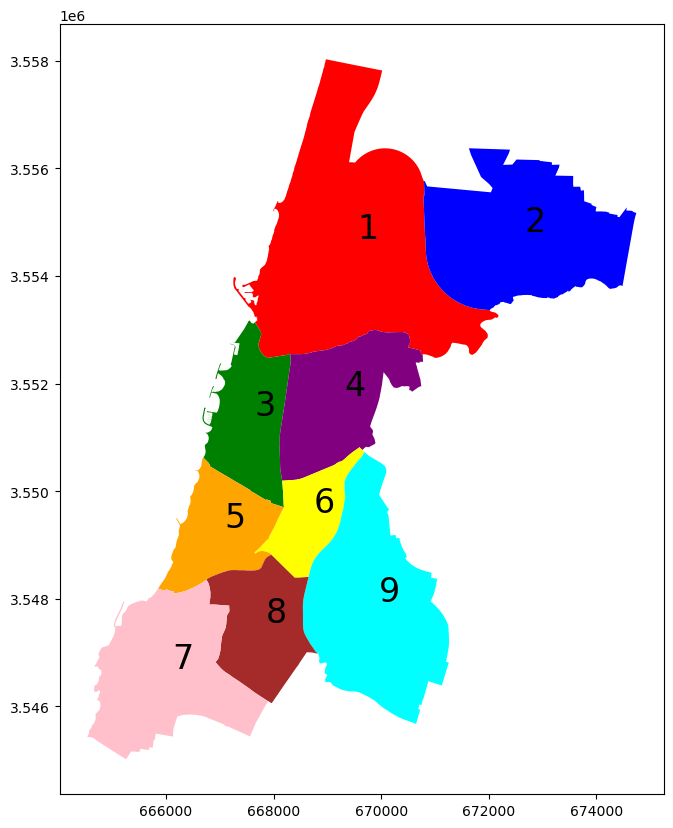

In [3]:
ta_q['index'] = ta_q.index

# Define a list of colors
color_map = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple',
    5: 'orange', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'cyan'
}

# Basic plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each shape with a different color from the list
for idx, row in ta_q.iterrows():
    color = color_map[row['krova']]  # Cycle through the colors list
    gpd.GeoSeries([row['geometry']]).plot(ax=ax, color=color)

    # Get the centroid of the polygon to place the text
    centroid = row['geometry'].centroid
    ax.annotate(text=row['krova'], xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=24, color='black')

plt.show()

In [4]:
# Exclude micro mobility
BICYCLE = 15
SCOOTER = 21
E_BICYCLE = 23
micro_m = [SCOOTER, E_BICYCLE, BICYCLE]


In [5]:
# Load original accident data
i_m_h_ta_gdf = gpd.read_parquet('./csv_tables/i_m_h_ta_gdf.parquet')

In [6]:
# Accidents that are not MM
i_m_h_ta_no_mm_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.involve_vehicle_type.isin(micro_m))].copy()

In [7]:
# Accidents that are just MM
i_m_h_ta_mm_gdf =  gpd.read_parquet('./csv_tables/i_m_h_ta_mm_gdf.parquet')
display(i_m_h_ta_mm_gdf.crs)
i_m_h_ta_mm_gdf.head(5)

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

accident_id  provider_and_id  provider_code  file_type_police  \
41    2013001368      32013001368              3                 3   
50    2013001742      32013001742              3                 3   
131   2013001350      12013001350              1                 1   
196   2013000147      12013000147              1                 1   
197   2013000147      12013000147              1                 1   

     involved_type involved_type_hebrew  license_acquiring_date  age_group  \
41               2             נהג נפגע                       0          6   
50               2             נהג נפגע                       0          7   
131              2             נהג נפגע                       0          5   
196              2             נהג נפגע                       0          8   
197              2             נהג נפגע                       0          6   

    age_group_hebrew  sex  ... vehicle_attribution  \
41             25-29    1  ...                 1.0   
50             30-34    2  ...                 1.0   
131            20-24    1  ...                 1.0   
196            35-39    1  ...                 1.0   
197            25-29    1  ...                 1.0   

     vehicle_attribution_hebrew seats  total_weight total_weight_hebrew  \
41                       ישראלי  99.0           0.0             לא ידוע   
50                       ישראלי  99.0           0.0             לא ידוע   
131                      ישראלי  99.0           0.0             לא ידוע   
196                      ישראלי  99.0           0.0             לא ידוע   
197                      ישראלי  99.0           0.0             לא ידוע   

     vehicle_damage vehicle_damage_hebrew  urban_intersection  \
41              4.0               אין נזק                 NaN   
50              4.0               אין נזק                 NaN   
131             4.0               אין נזק                 NaN   
196             2.0                בינוני           9110323.0   
197             2.0                בינוני           9110323.0   

           accident_date                        geometry  
41   2013-07-27 01:00:00  POINT (667544.749 3549959.961)  
50   2013-10-07 01:30:00  POINT (667286.918 3548726.540)  
131  2013-08-25 01:00:00  POINT (667023.688 3548785.170)  
196  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  
197  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  

[5 rows x 162 columns]

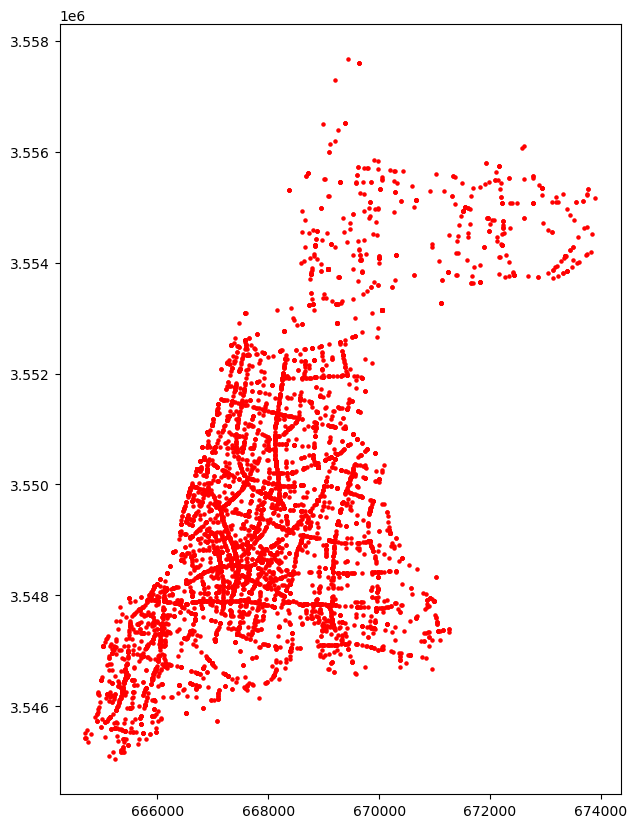

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
plt.show()

In [9]:
bp_ta_bp_and_meta = gpd.read_parquet('./csv_tables/bp_ta_bp_and_meta.parquet')
bp_ta_bp_and_meta.head(5)

oid_shvil  msorech           dateimport  create_year  \
0          1    95.10  14/08/2024 02:30:05         2012   
1          2   201.14  14/08/2024 02:30:05         2013   
2          3   696.31  14/08/2024 02:30:05         2004   
3          4   659.20  14/08/2024 02:30:05         2018   
4          5   362.67  14/08/2024 02:30:05         2018   

                                   shemmikta create_date  \
0                       נמיר מיוניצ'מן דרומה        None   
1                 פרופס מנמיר עד קדושי השואה        None   
2   יאיר רוזנבלום מאורי צבי גרינברג עד פרופס        None   
3                   קק"ל מנמיר עד חיים לבנון        None   
4  רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר        None   

                                            geometry  width direction  bitzua  \
0  LINESTRING (669823.985 3557373.860, 669855.549...    2.5   דו סטרי    2012   
1  LINESTRING (669232.834 3555478.027, 669169.381...    2.5   דו סטרי    2013   
2  LINESTRING (669232.637 3555478.023, 669249.025...    2.1   דו סטרי    2004   
3  LINESTRING (669354.261 3555417.055, 669410.178...    2.5   דו סטרי    2018   
4  LINESTRING (669946.350 3555344.516, 669962.261...    2.0   דו סטרי    2018   

  miflas date_created  
0   None         None  
1   None         None  
2   None         None  
3  מדרכה         None  
4   None   30/06/2018

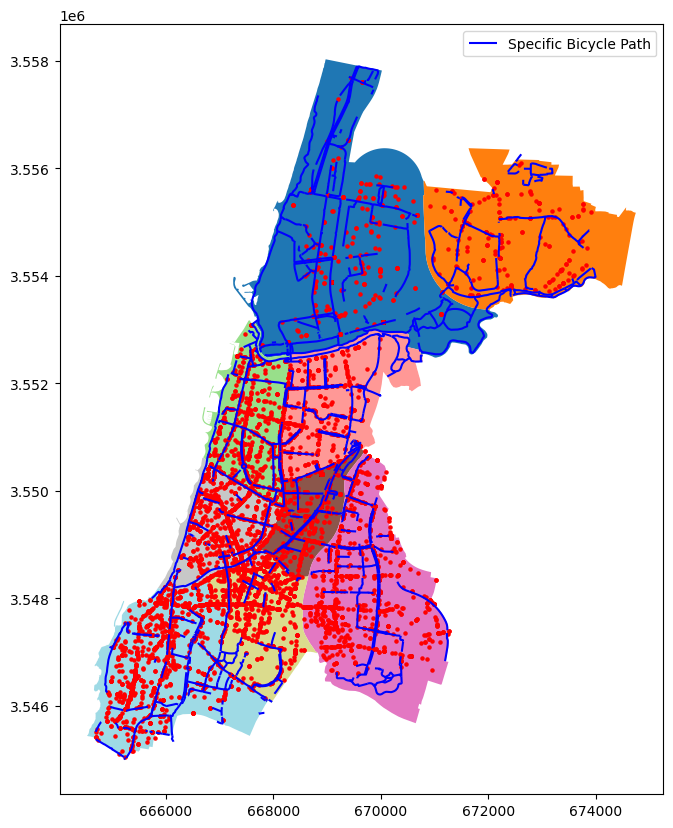

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

ta_q.plot(ax=ax, cmap='tab20', legend=True,)
bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )

plt.legend()
plt.show()

In [11]:
ta_streets = gpd.read_file('./csv_tables/TA_streets_20240724_031704/Streets.shp')
ta_streets

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
0           1.0    915.0  הרוגי מלכות   HARUGEY MALKHOT    336.0  רחוב   
1           2.0      0.0            0            UKNOWN      0.0  רחוב   
2           3.0    265.0      אמסטרדם         AMSTERDAM    516.0  רחוב   
3           4.0    644.0    אלון יגאל      YIG'AL ALLON   2524.0  רחוב   
4           5.0    634.0      מרגולין          MARGOLIN   2649.0  רחוב   
...         ...      ...          ...               ...      ...   ...   
8874     9851.0   3007.0   שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8875     9852.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8876     9853.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8877     9855.0   3907.0         3907              None   1703.0  רחוב   
8878     9857.0     34.0        מטלון           MATALON   2327.0  רחוב   

      kkivun   UniqueId       shemarvit  kreka  \
0        0.0  507-10001       قتل مملكة  100.0   
1        3.0  507-10002            None  100.0   
2        1.0  507-10003        أمستردام  100.0   
3        0.0  507-10004      ألون ييغال  200.0   
4        1.0  507-10005        مارغولين  100.0   
...      ...        ...             ...    ...   
8874     0.0  507-17843   قبائل إسرائيل  100.0   
8875     0.0  507-20562  Avinri Yitzhak  100.0   
8876     0.0  507-20563  Avinri Yitzhak  100.0   
8877     0.0  507-21960            3907  100.0   
8878     0.0  507-21966         ميتالون  100.0   

                                               geometry  
0     LINESTRING (672865.880 3554095.253, 672895.216...  
1     LINESTRING (666990.498 3551436.940, 667065.337...  
2     LINESTRING (667879.712 3551424.162, 667940.741...  
3     LINESTRING (669570.036 3550420.535, 669581.404...  
4     LINESTRING (669329.153 3548322.758, 669409.403...  
...                                                 ...  
8874  LINESTRING (665771.816 3547023.159, 665760.256...  
8875  LINESTRING (665585.719 3547178.152, 665627.936...  
8876  LINESTRING (665700.142 3547064.296, 665759.119...  
8877  LINESTRING (665087.059 3546677.092, 665075.120...  
8878  LINESTRING (666917.433 3548291.622, 666930.486...  

[8879 rows x 11 columns]

### Checking CSV with crossroads data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


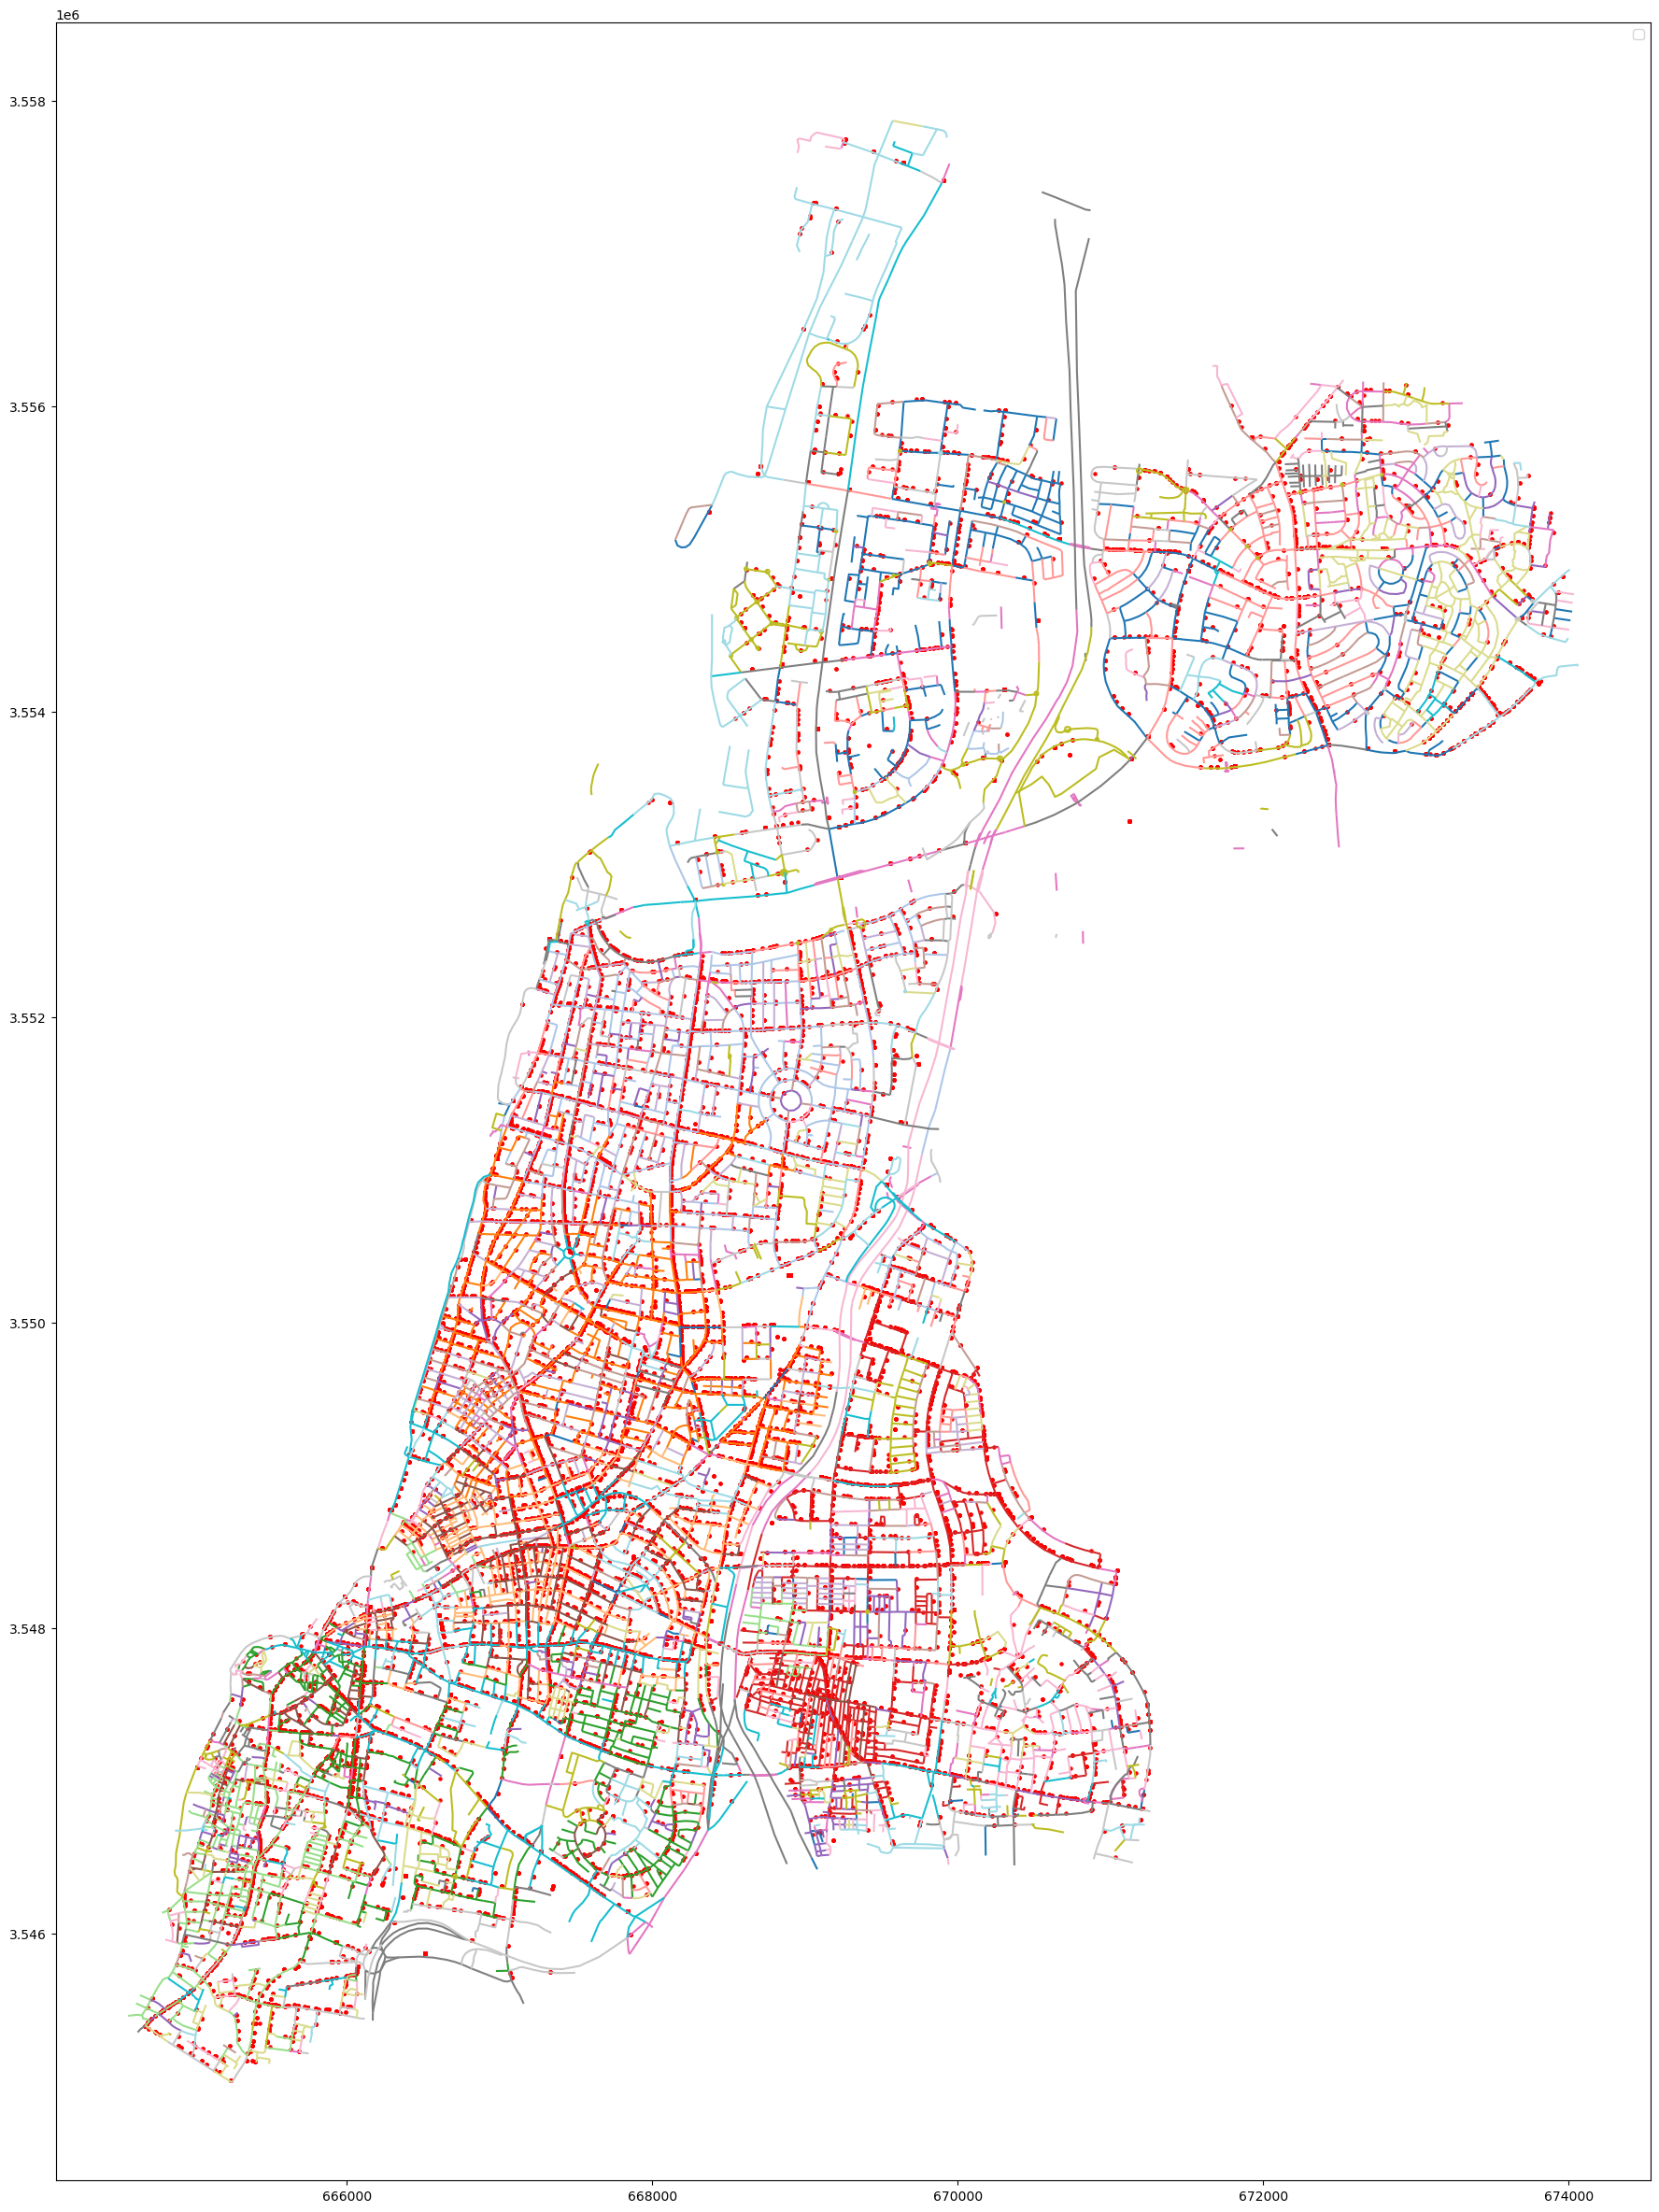

In [12]:

fig, ax = plt.subplots(figsize=(30, 30))
i_m_h_ta_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "רח 1062"].plot(ax=ax, color='black', marker='o', markersize=25, alpha=0.5 )


ta_streets.plot(ax=ax, cmap='tab20')

# accidents_on_street.plot(ax=ax, color='black', label='Specific Bicycle Path', linewidth=5)
# ta_streets[ta_streets.trechov == "מוסנזון בן-ציון דר'"].plot(ax=ax, color='black',linewidth=5)
# ta_streets[ta_streets.trechov == "ח'"].plot(ax=ax, color='black',linewidth=5)
# ta_streets[ta_streets.trechov == "סטימצקי אביגדור"].plot(ax=ax, color='black',linewidth=5)

# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# accidents_on_street.plot(ax=ax, color='black', marker='o', markersize=15 )
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "אורי"].plot(ax=ax, color='black', marker='o', markersize=15 )


plt.legend()
plt.show()

#### Loading crossroad data:
This data is for crosswalk, there are crossroads with out a crosswalk

Buffering the multi linestring and merging them to a single polygon.

In [13]:
from shapely.ops import unary_union

As you can see the are crosswalk that still overlap each other.

-------

Second attempt

In [182]:
ta_crossroads = gpd.read_file('./../../Downloads/811/811/811.shp')
print(ta_crossroads.crs)

ta_crossroads = ta_crossroads.to_crs('32636')

ta_crossroads_ = ta_crossroads.copy()
print(ta_crossroads_.crs)

EPSG:2039
EPSG:32636


In [183]:
ta_crossroads.geometry.convex_hull

0       POLYGON ((669690.613 3557655.299, 669687.814 3...
1       POLYGON ((670181.042 3553411.654, 670181.038 3...
2       POLYGON ((669403.776 3552766.542, 669402.685 3...
3       POLYGON ((669637.330 3555701.059, 669634.335 3...
4       POLYGON ((665262.797 3545602.617, 665262.699 3...
                              ...                        
7632    POLYGON ((671004.898 3547615.293, 671003.739 3...
7633    POLYGON ((666712.936 3550320.354, 666710.306 3...
7634    POLYGON ((669825.220 3554845.115, 669822.262 3...
7635    POLYGON ((670152.332 3554994.434, 670150.418 3...
7636    POLYGON ((670546.005 3555005.784, 670544.898 3...
Length: 7637, dtype: geometry

In [184]:
ta_crossroads_.head()

traffic_si  traffic__1  traffic_su  last_updat  status_dat  survey_dat  \
0     2040439         811    9.735025  2017-10-01  2017-09-28  2017-09-15   
1     2031701         811    6.523980  2017-10-15  2017-10-04  2017-09-25   
2     2012851         811    3.832506  2017-10-15  2017-10-04  2017-09-20   
3     2009209         811    4.218764  2018-03-06  2017-08-31  2017-08-02   
4     1076995         811    6.469185  2019-01-13  2019-01-10  2019-01-03   

            date_impor  Shape_Leng subject_ch            Descriptio  \
0  15/05/2024 02:28:24   30.000006       None  מעבר חציה להולכי רגל   
1  15/05/2024 02:28:24   20.999978       None  מעבר חציה להולכי רגל   
2  15/05/2024 02:28:24   12.000106       None  מעבר חציה להולכי רגל   
3  15/05/2024 02:28:24   15.000033       None  מעבר חציה להולכי רגל   
4  15/05/2024 02:28:24   21.000049       None  מעבר חציה להולכי רגל   

                                            geometry  
0  MULTILINESTRING ((669691.050 3557664.775, 6696...  
1  MULTILINESTRING ((670184.042 3553411.660, 6701...  
2  MULTILINESTRING ((669406.291 3552768.178, 6694...  
3  MULTILINESTRING ((669634.554 3555705.217, 6696...  
4  MULTILINESTRING ((665268.696 3545605.810, 6652...

In [185]:
ta_crossroads_.shape

(7637, 11)

In [186]:
# Buffer each geometry and create convex hull if needed
ta_crossroads_['geometry'] = ta_crossroads_.geometry.convex_hull.buffer(10)  # Adjust buffer size

# Combine all geometries into a single multipolygon with merged overlaps
# This step will merge any overlapping polygons into a single geometry
merged_geometry = unary_union(ta_crossroads_.geometry)

# If you want each connected component as a separate polygon, convert the multipolygon back to individual polygons
merged_gdf = gpd.GeoDataFrame(geometry=[merged_geometry], crs=ta_crossroads_.crs)

# Explode into individual polygons if merged into a MultiPolygon
merged_gdf = merged_gdf.explode(index_parts=True).reset_index(drop=True)

In [187]:
merged_gdf

geometry
0     POLYGON ((665236.305 3545032.614, 665235.706 3...
1     POLYGON ((665191.334 3545061.628, 665190.763 3...
2     POLYGON ((665152.023 3545087.512, 665151.480 3...
3     POLYGON ((665169.380 3545149.282, 665169.097 3...
4     POLYGON ((665005.047 3545179.336, 665004.391 3...
...                                                 ...
2909  POLYGON ((666639.398 3549715.946, 666638.841 3...
2910  POLYGON ((667951.101 3549721.718, 667950.866 3...
2911  POLYGON ((668095.419 3549718.909, 668095.180 3...
2912  POLYGON ((667358.461 3549733.296, 667357.698 3...
2913  POLYGON ((667695.956 3549731.804, 667695.914 3...

[2914 rows x 1 columns]

In [181]:
# Buffer each MultiLineString geometry
ta_crossroads_['geometry'] = ta_crossroads_.geometry.convex_hull
ta_crossroads_['geometry'] = ta_crossroads_['geometry'].buffer(10)

In [149]:
ta_crossroads_

traffic_si  traffic__1  traffic_su  last_updat  status_dat  survey_dat  \
0        2040439         811    9.735025  2017-10-01  2017-09-28  2017-09-15   
1        2031701         811    6.523980  2017-10-15  2017-10-04  2017-09-25   
2        2012851         811    3.832506  2017-10-15  2017-10-04  2017-09-20   
3        2009209         811    4.218764  2018-03-06  2017-08-31  2017-08-02   
4        1076995         811    6.469185  2019-01-13  2019-01-10  2019-01-03   
...          ...         ...         ...         ...         ...         ...   
7632     3141652         811    5.760778  2024-03-28  2024-03-28        None   
7633     3141845         811    6.743645  2024-04-10  2024-04-10        None   
7634     3127297         811    7.135185  2022-10-02  2022-10-02        None   
7635     2010808         811    9.601133  2018-03-06  2017-08-31  2017-08-15   
7636     2010931         811    6.143144  2018-03-06  2017-08-31  2017-08-15   

               date_impor  Shape_Leng  subject_ch            Descriptio  \
0     15/05/2024 02:28:24   30.000006        None  מעבר חציה להולכי רגל   
1     15/05/2024 02:28:24   20.999978        None  מעבר חציה להולכי רגל   
2     15/05/2024 02:28:24   12.000106        None  מעבר חציה להולכי רגל   
3     15/05/2024 02:28:24   15.000033        None  מעבר חציה להולכי רגל   
4     15/05/2024 02:28:24   21.000049        None  מעבר חציה להולכי רגל   
...                   ...         ...         ...                   ...   
7632  15/05/2024 02:28:24   18.000095  1900-01-01  מעבר חציה להולכי רגל   
7633  15/05/2024 02:28:24   19.600009  1900-01-01  מעבר חציה להולכי רגל   
7634  15/05/2024 02:28:24   24.000102  1900-01-01  מעבר חציה להולכי רגל   
7635  15/05/2024 02:28:24   29.999906        None  מעבר חציה להולכי רגל   
7636  15/05/2024 02:28:24   20.999949        None  מעבר חציה להולכי רגל   

                                               geometry  
0     POLYGON ((669699.944 3557651.702, 669699.546 3...  
1     POLYGON ((670181.065 3553401.654, 670180.084 3...  
2     POLYGON ((669409.230 3552758.160, 669408.382 3...  
3     POLYGON ((669647.315 3555700.511, 669647.214 3...  
4     POLYGON ((665263.122 3545592.622, 665262.141 3...  
...                                                 ...  
7632  POLYGON ((671008.762 3547606.070, 671007.839 3...  
7633  POLYGON ((666722.326 3550316.916, 666721.944 3...  
7634  POLYGON ((669835.083 3554843.462, 669834.873 3...  
7635  POLYGON ((670161.901 3554991.529, 670161.570 3...  
7636  POLYGON ((670549.695 3554996.490, 670548.766 3...  

[7637 rows x 11 columns]

In [150]:
# import libpysal

# # create spatial weights matrix
# W = libpysal.weights.Queen.from_dataframe(ta_crossroads_)

# # get component labels
# components = W.component_labels

# combined_polygons = ta_crossroads_.dissolve(by=components)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


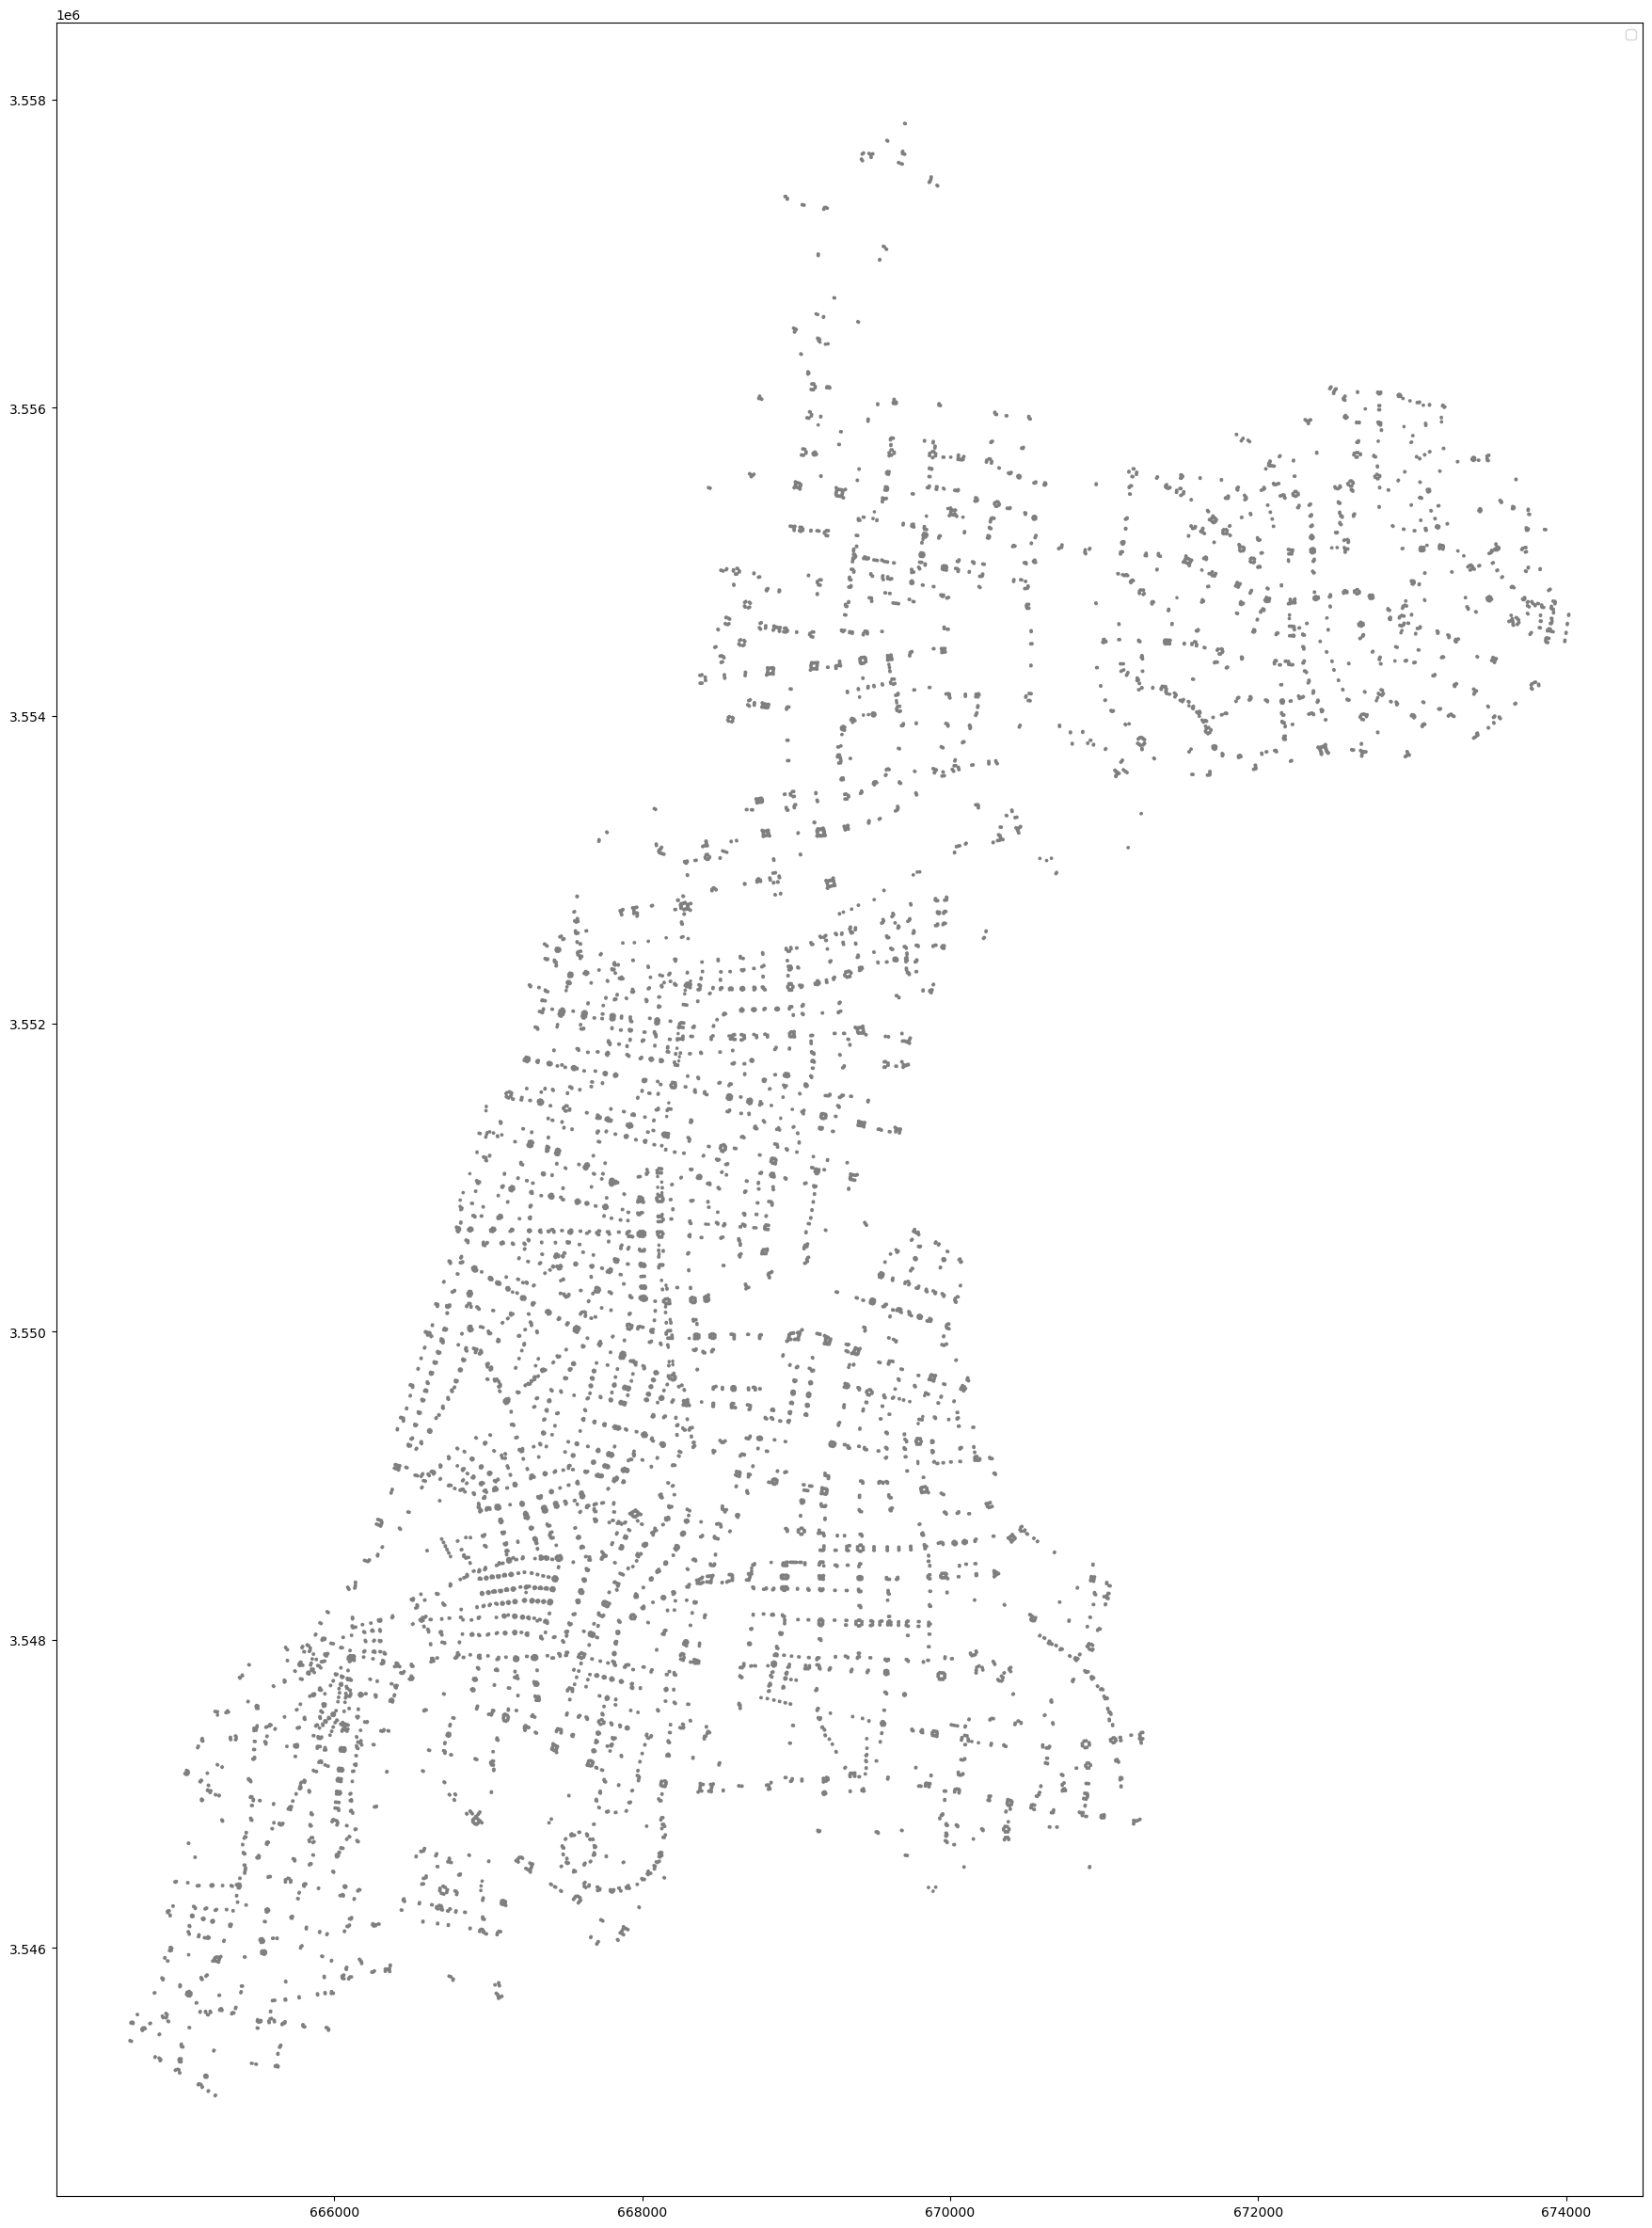

In [188]:
fig, ax = plt.subplots(figsize=(30, 30))
# i_m_h_ta_gdf.plot(ax=ax, color='black', marker='o', markersize=5 )
# i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5 )


# ta_crossroads_[ta_crossroads_.traffic_si ==  2031701].plot(ax=ax, color='black', linewidth=5, alpha=0.5)
merged_gdf.plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

#### Get the accidents that intersect the crosswalks

In [152]:
i_m_h_ta_mm_gdf.shape

(8789, 162)

In [153]:
i_m_h_ta_mm_gdf_ = i_m_h_ta_mm_gdf.drop_duplicates(subset=['provider_and_id'])
i_m_h_ta_mm_gdf_ = i_m_h_ta_mm_gdf_[i_m_h_ta_mm_gdf_.location_accuracy == 1]

i_m_h_ta_mm_gdf_.shape

(4997, 162)

In [190]:
i_m_h_ta_mm_crossroads_gdf = gpd.sjoin(i_m_h_ta_mm_gdf_, merged_gdf, how='inner', predicate='intersects')
# print(i_m_h_ta_mm_crossroads_gdf.shape, i_m_h_ta_mm_crossroads_gdf.duplicated(subset=['provider_and_id']).sum(),  i_m_h_ta_mm_crossroads_gdf.duplicated(subset=['traffic_si']).sum())

# i_m_h_ta_mm_crossroads_gdf.drop_duplicates(subset=['provider_and_id']).shape, i_m_h_ta_mm_crossroads_gdf.drop_duplicates(subset=['traffic_si']).shape

In [191]:
i_m_h_ta_mm_crossroads_gdf_ = i_m_h_ta_mm_crossroads_gdf.drop_duplicates(subset=['provider_and_id'])
i_m_h_ta_mm_crossroads_gdf_

accident_id  provider_and_id  provider_code  file_type_police  \
196      2013000147      12013000147              1                 1   
251      2013001755      32013001755              3                 3   
257      2013002105      32013002105              3                 3   
349      2013001346      32013001346              3                 3   
455      2013002036      12013002036              1                 1   
...             ...              ...            ...               ...   
111269   2024098273      32024098273              3                 3   
111326   2024098833      32024098833              3                 3   
111332   2024090432      12024090432              1                 1   
111345   2024096932      32024096932              3                 3   
111394   2024095204      32024095204              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
196                 2             נהג נפגע                       0          8   
251                 2             נהג נפגע                    2005          6   
257                 1                  נהג                       0          7   
349                 2             נהג נפגע                       0          5   
455                 2             נהג נפגע                       0          6   
...               ...                  ...                     ...        ...   
111269              2             נהג נפגע                    1980         13   
111326              1                  נהג                       0         99   
111332              2             נהג נפגע                    1996         10   
111345              2             נהג נפגע                    2023          4   
111394              2             נהג נפגע                    2013          7   

       age_group_hebrew  sex  ... vehicle_attribution_hebrew  seats  \
196               35-39    1  ...                     ישראלי   99.0   
251               25-29    1  ...                     ישראלי   99.0   
257               30-34    1  ...                     ישראלי   99.0   
349               20-24    2  ...                     ישראלי   99.0   
455               25-29    2  ...                     ישראלי   99.0   
...                 ...  ...  ...                        ...    ...   
111269            60-64    1  ...                     ישראלי   99.0   
111326          לא ידוע    0  ...                     ישראלי   99.0   
111332            45-49    2  ...                     ישראלי   99.0   
111345            15-19    1  ...                     ישראלי   99.0   
111394            30-34    1  ...                     ישראלי   99.0   

       total_weight  total_weight_hebrew vehicle_damage  \
196             0.0              לא ידוע            2.0   
251             0.0              לא ידוע            4.0   
257             0.0              לא ידוע            1.0   
349             0.0              לא ידוע            4.0   
455             0.0              לא ידוע            4.0   
...             ...                  ...            ...   
111269          0.0              לא ידוע            1.0   
111326          0.0              לא ידוע            4.0   
111332          0.0              לא ידוע            1.0   
111345          0.0              לא ידוע            4.0   
111394          0.0              לא ידוע            4.0   

        vehicle_damage_hebrew urban_intersection        accident_date  \
196                    בינוני          9110323.0  2013-09-19 00:00:00   
251                   אין נזק         11670545.0  2013-11-23 01:30:00   
257                        קל          7540321.0  2013-01-01 02:15:00   
349                   אין נזק            10335.0  2013-09-06 01:00:00   
455                   אין נזק          7190312.0  2013-07-25 02:00:00   
...                       ...                ...                  ...   
111269                     קל         15270924.0  2024-03-31 08:00:00   
111326      

In [193]:
i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')

index_right
1065    32
1058    30
1430    21
1709    19
962     18
        ..
1201     1
1196     1
1193     1
1192     1
0        1
Name: count, Length: 749, dtype: int64

In [194]:
t10_crossroad_id = i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right').head(10).index
t10_crossroad_id

Index([1065, 1058, 1430, 1709, 962, 1464, 874, 1384, 685, 965], dtype='int64', name='index_right')

In [196]:
t10_crossroad_id = i_m_h_ta_mm_crossroads_gdf.value_counts(subset='index_right').head(10).index
i_m_h_ta_mm_crossroads_gdf_t10 = i_m_h_ta_mm_crossroads_gdf[i_m_h_ta_mm_crossroads_gdf.index_right.isin(t10_crossroad_id)]
i_m_h_ta_mm_crossroads_gdf_t10

accident_id  provider_and_id  provider_code  file_type_police  \
580      2013004110      12013004110              1                 1   
2759     2013015911      12013015911              1                 1   
4865     2013024676      12013024676              1                 1   
7642     2013037036      12013037036              1                 1   
9775     2013043911      12013043911              1                 1   
...             ...              ...            ...               ...   
109867   2024040748      12024040748              1                 1   
109917   2024041727      12024041727              1                 1   
109962   2024037537      32024037537              3                 3   
110204   2024051752      32024051752              3                 3   
111249   2024095525      32024095525              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
580                 2             נהג נפגע                       0          7   
2759                2             נהג נפגע                       0          7   
4865                1                  נהג                       0          7   
7642                1                  נהג                       0          9   
9775                2             נהג נפגע                    2002          6   
...               ...                  ...                     ...        ...   
109867              2             נהג נפגע                    2008          7   
109917              2             נהג נפגע                    1985         14   
109962              1                  נהג                       0         99   
110204              2             נהג נפגע                       0         99   
111249              2             נהג נפגע                       0         99   

       age_group_hebrew  sex  ... vehicle_attribution_hebrew  seats  \
580               30-34    1  ...                     ישראלי   99.0   
2759              30-34    2  ...                     ישראלי   99.0   
4865              30-34    1  ...                     ישראלי   99.0   
7642              40-44    1  ...                     ישראלי   99.0   
9775              25-29    1  ...                     ישראלי   99.0   
...                 ...  ...  ...                        ...    ...   
109867            30-34    1  ...                     ישראלי   99.0   
109917            65-69    1  ...                     ישראלי   99.0   
109962          לא ידוע    0  ...                     ישראלי   99.0   
110204          לא ידוע    0  ...                     ישראלי   99.0   
111249          לא ידוע    0  ...                     ישראלי   99.0   

       total_weight  total_weight_hebrew vehicle_damage  \
580             0.0              לא ידוע            1.0   
2759            0.0              לא ידוע            1.0   
4865            0.0              לא ידוע            1.0   
7642            0.0              לא ידוע            4.0   
9775            0.0              לא ידוע            1.0   
...             ...                  ...            ...   
109867          0.0              לא ידוע            4.0   
109917          0.0              לא ידוע            4.0   
109962          0.0              לא ידוע            4.0   
110204          0.0              לא ידוע            1.0   
111249          0.0              לא ידוע            1.0   

        vehicle_damage_hebrew urban_intersection        accident_date  \
580                        קל         12280911.0  2013-04-24 06:30:00   
2759                       קל         13320815.0  2013-04-22 09:45:00   
4865                       קל         12280911.0  2013-09-25 12:15:00   
7642                  אין נזק                NaN  2013-02-25 15:30:00   
9775                       קל         12950556.0  2013-07-04 16:45:00   
...                       ...                ...                  ...   
109867                אין נזק         15130624.0  2024-01-08 12:00:00   
109917      

In [197]:
ta_crossroads.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [203]:
i_m_h_ta_mm_crossroads_gdf_t10

accident_id  provider_and_id  provider_code  file_type_police  \
580      2013004110      12013004110              1                 1   
2759     2013015911      12013015911              1                 1   
4865     2013024676      12013024676              1                 1   
7642     2013037036      12013037036              1                 1   
9775     2013043911      12013043911              1                 1   
...             ...              ...            ...               ...   
109867   2024040748      12024040748              1                 1   
109917   2024041727      12024041727              1                 1   
109962   2024037537      32024037537              3                 3   
110204   2024051752      32024051752              3                 3   
111249   2024095525      32024095525              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
580                 2             נהג נפגע                       0          7   
2759                2             נהג נפגע                       0          7   
4865                1                  נהג                       0          7   
7642                1                  נהג                       0          9   
9775                2             נהג נפגע                    2002          6   
...               ...                  ...                     ...        ...   
109867              2             נהג נפגע                    2008          7   
109917              2             נהג נפגע                    1985         14   
109962              1                  נהג                       0         99   
110204              2             נהג נפגע                       0         99   
111249              2             נהג נפגע                       0         99   

       age_group_hebrew  sex  ... vehicle_attribution_hebrew  seats  \
580               30-34    1  ...                     ישראלי   99.0   
2759              30-34    2  ...                     ישראלי   99.0   
4865              30-34    1  ...                     ישראלי   99.0   
7642              40-44    1  ...                     ישראלי   99.0   
9775              25-29    1  ...                     ישראלי   99.0   
...                 ...  ...  ...                        ...    ...   
109867            30-34    1  ...                     ישראלי   99.0   
109917            65-69    1  ...                     ישראלי   99.0   
109962          לא ידוע    0  ...                     ישראלי   99.0   
110204          לא ידוע    0  ...                     ישראלי   99.0   
111249          לא ידוע    0  ...                     ישראלי   99.0   

       total_weight  total_weight_hebrew vehicle_damage  \
580             0.0              לא ידוע            1.0   
2759            0.0              לא ידוע            1.0   
4865            0.0              לא ידוע            1.0   
7642            0.0              לא ידוע            4.0   
9775            0.0              לא ידוע            1.0   
...             ...                  ...            ...   
109867          0.0              לא ידוע            4.0   
109917          0.0              לא ידוע            4.0   
109962          0.0              לא ידוע            4.0   
110204          0.0              לא ידוע            1.0   
111249          0.0              לא ידוע            1.0   

        vehicle_damage_hebrew urban_intersection        accident_date  \
580                        קל         12280911.0  2013-04-24 06:30:00   
2759                       קל         13320815.0  2013-04-22 09:45:00   
4865                       קל         12280911.0  2013-09-25 12:15:00   
7642                  אין נזק                NaN  2013-02-25 15:30:00   
9775                       קל         12950556.0  2013-07-04 16:45:00   
...                       ...                ...                  ...   
109867                אין נזק         15130624.0  2024-01-08 12:00:00   
109917      

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


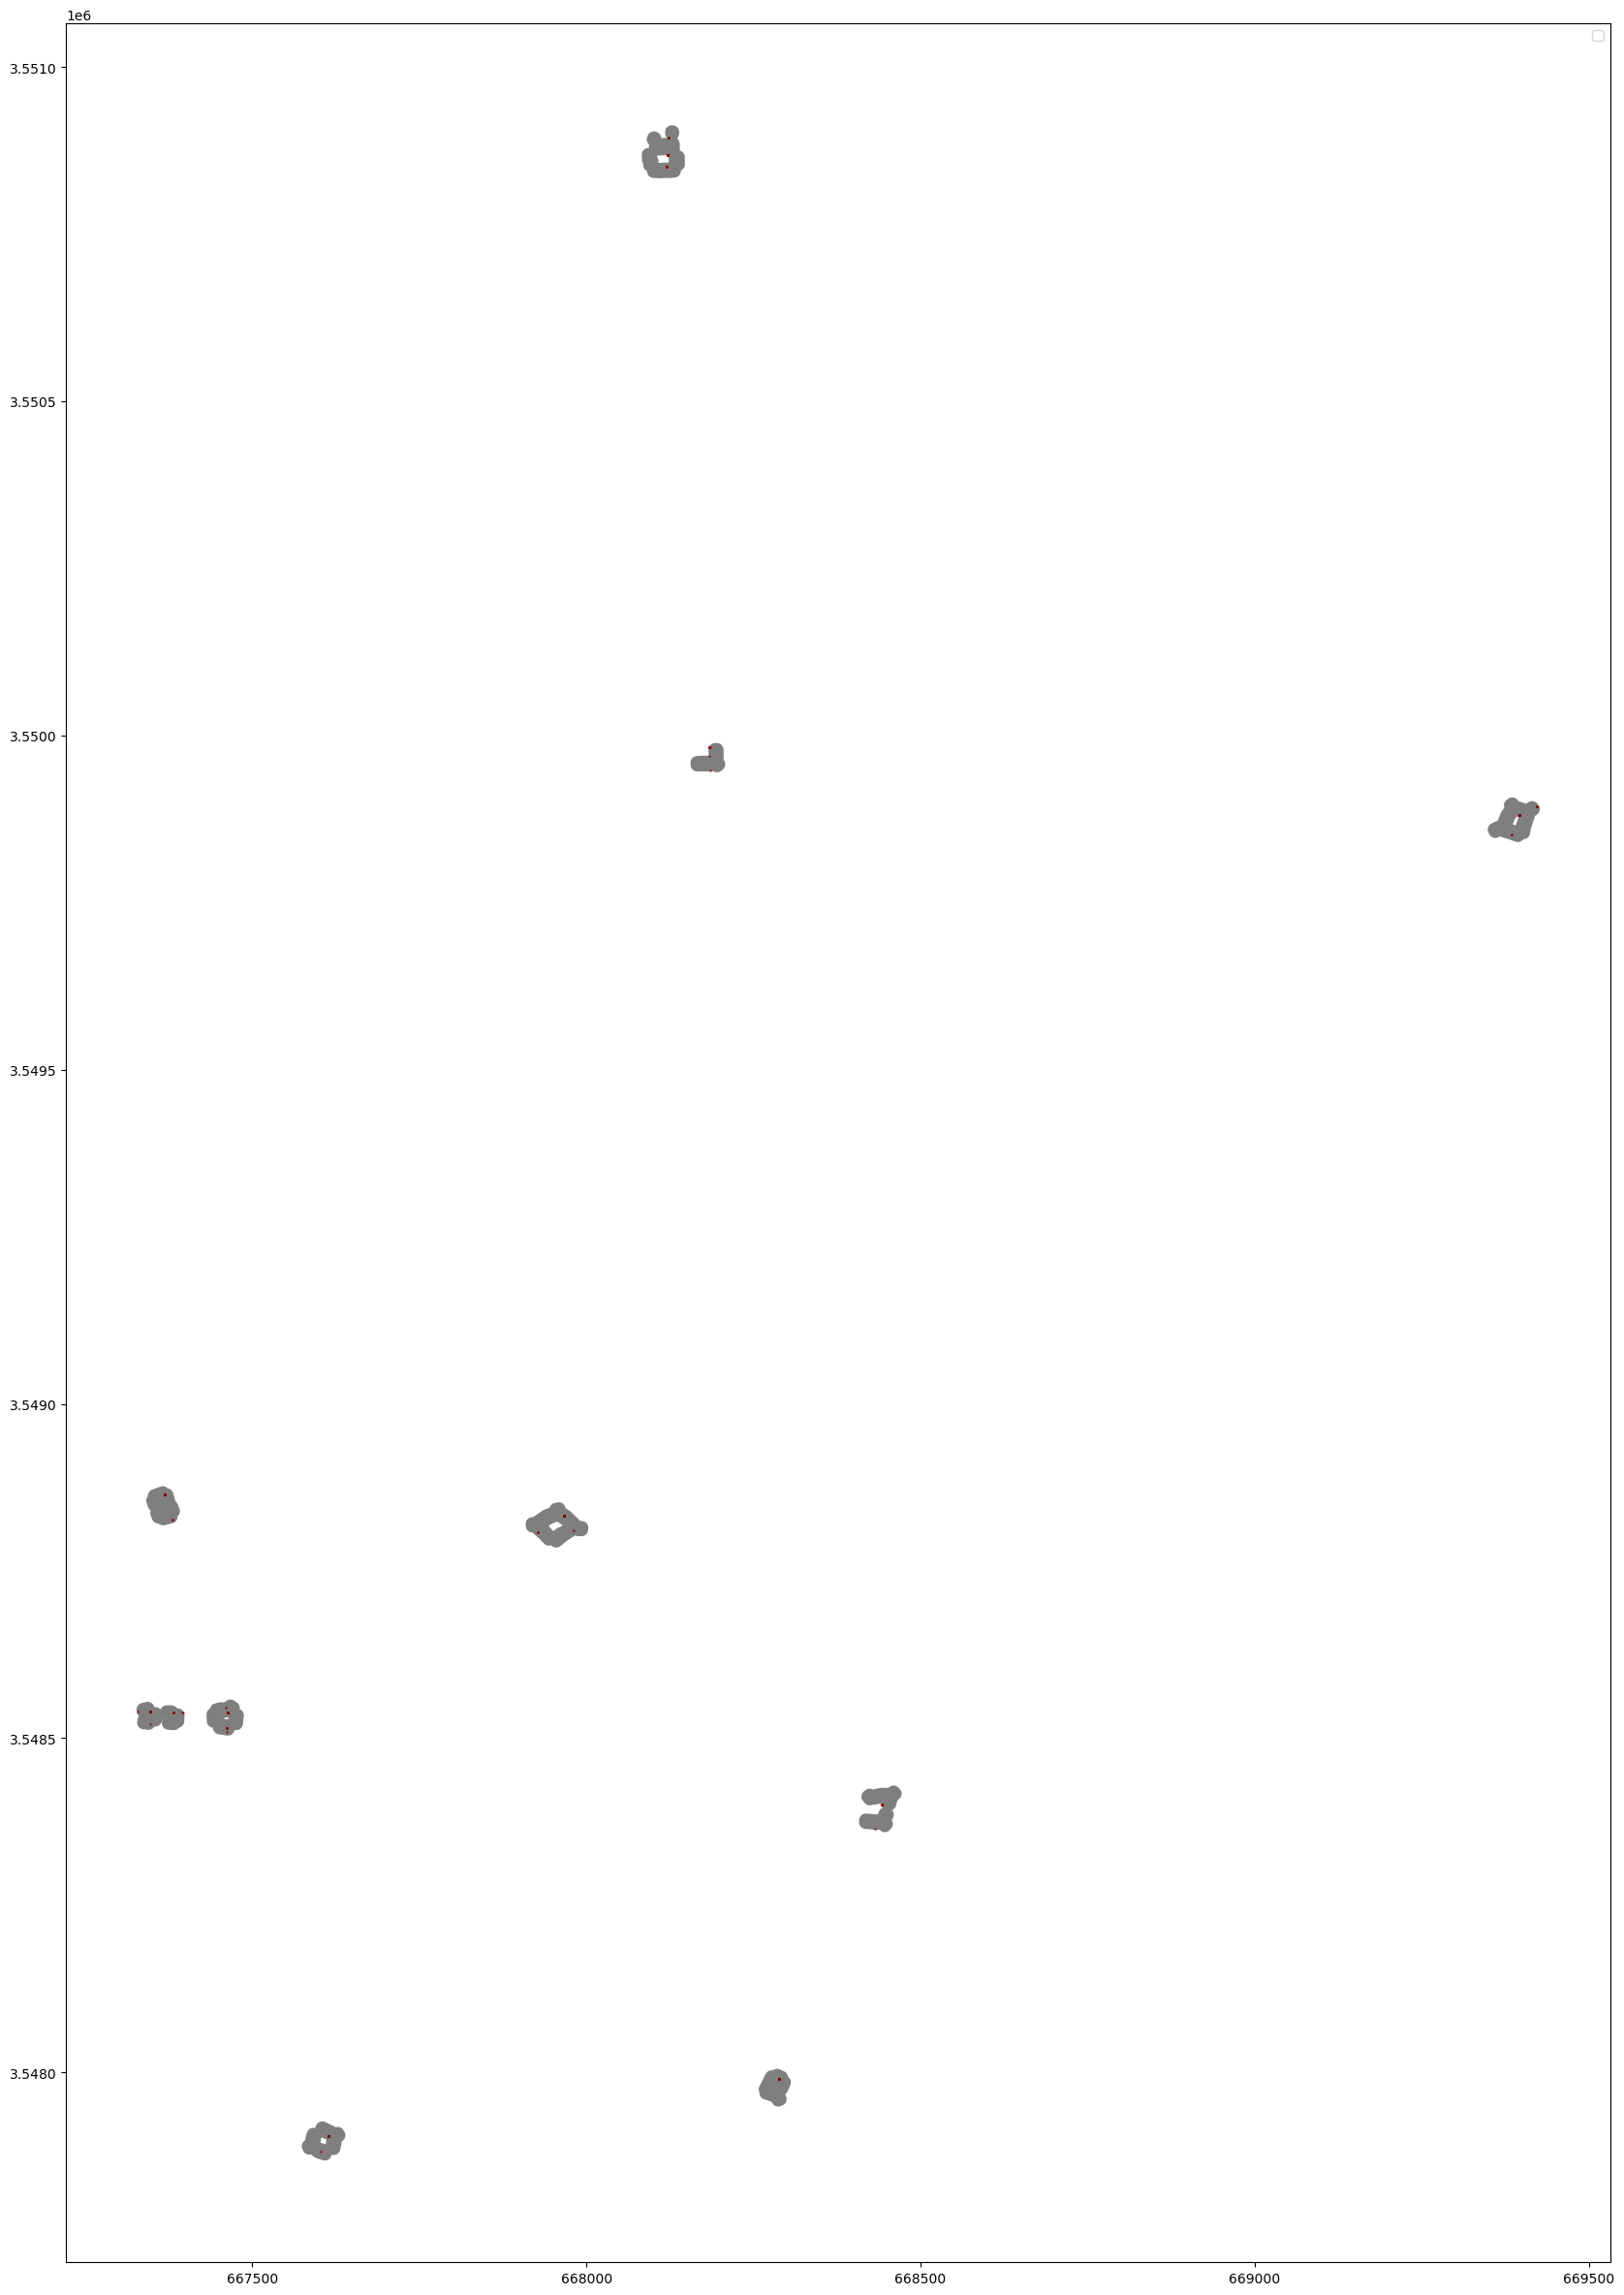

In [204]:
fig, ax = plt.subplots(figsize=(30, 30))
# i_m_h_ta_gdf.plot(ax=ax, color='black', marker='o', markersize=5 )
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "רח 1062"].plot(ax=ax, color='black', marker='o', markersize=25, alpha=0.5 )

# i_m_h_ta_mm_crossroads_gdf_t10[i_m_h_ta_mm_crossroads_gdf_t10.traffic_si == 2068313].plot(ax=ax, color='blue', marker='o', markersize=1, alpha=0.5 )
# i_m_h_ta_mm_crossroads_gdf_t10[i_m_h_ta_mm_crossroads_gdf_t10.traffic_si == 2083789].plot(ax=ax, color='red', marker='o', markersize=1, alpha=0.5 )

i_m_h_ta_mm_crossroads_gdf_t10.plot(ax=ax, color='red', marker='o', markersize=1, alpha=0.5 )
merged_gdf[merged_gdf.index.isin(i_m_h_ta_mm_crossroads_gdf_t10.index_right)].plot(ax=ax, color='black', alpha=0.5 )
# ta_crossroads_[ta_crossroads_.traffic_si == 2068313].plot(ax=ax, color='black', linewidth=5, alpha=0.5 )
# ta_crossroads_[ta_crossroads_.traffic_si == 2083789].plot(ax=ax, color='black', linewidth=5, alpha=0.5 )
# i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5 )


# i_m_h_ta_mm_crossroads_gdf_t10.plot(ax=ax, color='blue', marker='o', markersize=5, alpha=1 )

# ta_crossroads[ta_crossroads.traffic_si.isin(i_m_h_ta_mm_crossroads_gdf_t10.traffic_si)].plot(ax=ax, color='black', alpha=1 )
# ta_crossroads_[ta_crossroads_.traffic_si.isin(i_m_h_ta_mm_crossroads_gdf_t10.traffic_si)].plot(ax=ax, color='black',markersize=125, alpha=0.5 )

# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[0]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )
# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[1]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )
# ta_crossroads[ta_crossroads.traffic_si==t10_crossroad_id[0]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )
# ta_crossroads[ta_crossroads.traffic_si==t10_crossroad_id[1]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )


# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[2]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )

# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[3]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )

# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[4]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )

# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[5]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )

# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[6]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )

# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[7]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )

# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[8]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )
# ta_crossroads_[ta_crossroads_.traffic_si==t10_crossroad_id[9]].plot(ax=ax, color='black', marker='o', markersize=5, alpha=0.51 )




plt.legend()
plt.show()

#### Plotting intersected accident 

#### Loading streets to be matched using intersections

In [12]:
matched_streets_fix_with_intersection = pd.read_csv('./csv_tables/matched_streets_fix_with_intersection.csv')
# matched_streets_fix_with_intersection

ta_streets_to_fix_with_intersection = matched_streets_fix_with_intersection['ta_street'].unique()

i_m_h_streets_to_fix_with_intersection = matched_streets_fix_with_intersection['i_m_h_street_name'].unique()
i_m_h_streets_to_fix_with_intersection,ta_streets_to_fix_with_intersection

(array(['רח 1019', 'רח 1062', 'רח 1081', 'רח 1096', 'רח 1098', 'רח 1103',
        'רח 1104', 'רח 1105', 'רח 1107', 'רח 1108', 'רח 1115', 'רח 1116',
        'רח 1118', 'רח 1174', 'רח 1184', 'רח 1185', 'רח 1188', 'רח 1206',
        'רח 1211', 'רח 1213', 'רח 1223', 'רח 1243', 'רח 1246', 'רח 1254',
        'רח 1260', 'רח 1265', 'רח 1271', 'רח 1274', 'רח 1275', 'רח 1276',
        'רח 1277', 'רח 1278', 'רח 1285', 'רח 1302', 'רח 2003', 'רח 2005',
        'רח 2007', 'רח 2040', 'רח 2080', 'רח 211', 'רח 2139', 'רח 2150',
        'רח 2170', 'רח 2184', 'רח 2185', 'רח 2203', 'רח 2221', 'רח 2222',
        'רח 2224', 'רח 2228', 'רח 2229', 'רח 2232', 'רח 2240', 'רח 2284',
        'רח 2286', 'רח 2287', 'רח 2288', 'רח 2289', 'רח 2290', 'רח 2291',
        'רח 2314', 'רח 2342', 'רח 2355', 'רח 2356', 'רח 2357', 'רח 3040',
        'רח 3053', 'רח 3055', 'רח 3070', 'רח 3071', 'רח 3083', 'רח 3142',
        'רח 3172', 'רח 3175', 'רח 3178', 'רח 3210', 'רח 3226', 'רח 3241',
        'רח 3288', 'רח 3312', 'רח 3320'

In [13]:
i_m_h_ta_gdf_fix_with_intersection = i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.isin(i_m_h_streets_to_fix_with_intersection)].copy()
# ta_streets_fix_with_intersection = ta_streets[ta_streets.trechov.isin(ta_streets_to_fix_with_intersection)].copy()

ta_streets_buffered = ta_streets.copy()
ta_streets_buffered.geometry = ta_streets_buffered.geometry.buffer(10)
# ta_streets_fix_with_intersection.geometry = ta_streets_fix_with_intersection.geometry.buffer(10)
ta_i_m_h_intersection = gpd.sjoin(ta_streets_buffered, i_m_h_ta_gdf_fix_with_intersection , how='inner', predicate='intersects')

# ta_i_m_h_intersection = gpd.sjoin(ta_streets_fix_with_intersection, i_m_h_ta_gdf_fix_with_intersection , how='inner', predicate='intersects')


ta_i_m_h_intersection

oidrechov  krechov         trechov         shemangli  mslamas  tsug  \
14         15.0    347.0  שפירא צבי הרמן    SHAPIRA HERMAN    747.0  רחוב   
14         15.0    347.0  שפירא צבי הרמן    SHAPIRA HERMAN    747.0  רחוב   
14         15.0    347.0  שפירא צבי הרמן    SHAPIRA HERMAN    747.0  רחוב   
14         15.0    347.0  שפירא צבי הרמן    SHAPIRA HERMAN    747.0  רחוב   
15         16.0     96.0          פרישמן          FRISHMAN    714.0  רחוב   
...         ...      ...             ...               ...      ...   ...   
8874     9851.0   3007.0      שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8874     9851.0   3007.0      שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8874     9851.0   3007.0      שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8874     9851.0   3007.0      שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8874     9851.0   3007.0      שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   

      kkivun   UniqueId          shemarvit  kreka  ... vehicle_status_hebrew  \
14       1.0  507-10017  شابيرو زفي هيرمان  100.0  ...                 השכרה   
14       1.0  507-10017  شابيرو زفي هيرمان  100.0  ...                  None   
14       1.0  507-10017  شابيرو زفي هيرمان  100.0  ...                  None   
14       1.0  507-10017  شابيرو زفي هيرمان  100.0  ...                  None   
15       0.0  507-10018            فريشمان  200.0  ...                  None   
...      ...        ...                ...    ...  ...                   ...   
8874     0.0  507-17843      قبائل إسرائيل  100.0  ...                  None   
8874     0.0  507-17843      قبائل إسرائيل  100.0  ...                  None   
8874     0.0  507-17843      قبائل إسرائيل  100.0  ...                  None   
8874     0.0  507-17843      قبائل إسرائيل  100.0  ...                  None   
8874     0.0  507-17843      قبائل إسرائيل  100.0  ...                  None   

      vehicle_attribution  vehicle_attribution_hebrew  seats  total_weight  \
14                    1.0                      ישראלי    3.0           1.0   
14                    1.0                      ישראלי   99.0           0.0   
14                    1.0                      ישראלי    1.0           1.0   
14                    1.0                      ישראלי    1.0           NaN   
15                    3.0                      משטרתי   99.0           0.0   
...                   ...                         ...    ...           ...   
8874                  1.0                      ישראלי    1.0           1.0   
8874                  1.0                      ישראלי    3.0           2.0   
8874                  1.0                      ישראלי    1.0           NaN   
8874                  1.0                      ישראלי    3.0           1.0   
8874                  NaN                        None    NaN           NaN   

      total_weight_hebrew  vehicle_damage vehicle_damage_hebrew  \
14                 עד 1.9             2.0                בינוני   
14                לא ידוע             4.0               אין נזק   
14                 עד 1.9             1.0                    קל   
14                   None             2.0                בינוני   
15                לא ידוע             4.0               אין נזק   
...                   ...             ...                   ...   
8874               עד 1.9             2.0                בינוני   
8874              2.0-2.9             4.0               אין נזק   
8874                 None             1.0                    קל   
8874               עד 1.9             1.0                    קל   
8874                 None             NaN                  None   

      urban_intersection        accident_date  
14             8890345.0  2020-05-19 12:30:00  
14             8890345.0  2017-03-22 08:00:00  
14             8890345.0  2017-03-22 08:00:00  
14             8890345.0  2020-05-19 12:30:00  
15                   NaN  2015-02-04 15:00:00  
...                  ...                  ...  
8874            300732.0  2020-01-01 08:15

In [14]:
ta_i_m_h_intersection[ta_i_m_h_intersection.trechov == "ח'"]

Empty GeoDataFrame
Columns: [oidrechov, krechov, trechov, shemangli, mslamas, tsug, kkivun, UniqueId, shemarvit, kreka, geometry, index_right, accident_id, provider_and_id, provider_code, file_type_police, involved_type, involved_type_hebrew, license_acquiring_date, age_group, age_group_hebrew, sex, sex_hebrew, involve_vehicle_type, involve_vehicle_type_hebrew, safety_measures, safety_measures_hebrew, involve_yishuv_symbol, involve_yishuv_name, injury_severity, injury_severity_hebrew, injured_type, injured_type_hebrew, injured_position, injured_position_hebrew, population_type, population_type_hebrew, involve_home_region, involve_home_region_hebrew, involve_home_district, involve_home_district_hebrew, involve_home_natural_area, involve_home_natural_area_hebrew, involve_home_municipal_status, involve_home_municipal_status_hebrew, involve_home_yishuv_shape, involve_home_yishuv_shape_hebrew, hospital_time, hospital_time_hebrew, medical_type, medical_type_hebrew, release_dest, release_dest_hebrew, safety_measures_use, safety_measures_use_hebrew, late_deceased, late_deceased_hebrew, car_id, involve_id, accident_year, accident_month, provider_code_hebrew, accident_timestamp, accident_type, accident_type_hebrew, accident_severity, accident_severity_hebrew, location_accuracy, location_accuracy_hebrew, road_type, road_type_hebrew, road_shape, road_shape_hebrew, day_type, day_type_hebrew, police_unit, police_unit_hebrew, one_lane, one_lane_hebrew, multi_lane, multi_lane_hebrew, speed_limit, speed_limit_hebrew, road_intactness, road_intactness_hebrew, road_width, road_width_hebrew, road_sign, road_sign_hebrew, road_light, road_light_hebrew, road_control, road_control_hebrew, weather, weather_hebrew, road_surface, road_surface_hebrew, road_object, road_object_hebrew, object_distance, ...]
Index: []

[0 rows x 173 columns]

#### Intersecting i_m_h_ta_gpd with ta_streets

In [15]:
# First drop all the duplicates position of accidents
i_m_h_no_geo_dup = i_m_h_ta_gdf.drop_duplicates(subset=['geometry'])

ta_streets_buffered = ta_streets.copy()
ta_streets_buffered.geometry = ta_streets_buffered.geometry.buffer(10)

# intersect ta_streets with i_m_h_no_geo_dup
ta_i_m_h_intersect = gpd.sjoin(i_m_h_no_geo_dup,ta_streets_buffered, how='inner', predicate='intersects')

ta_i_m_h_intersect = ta_i_m_h_intersect.drop_duplicates(subset=['geometry'])

ta_i_m_h_intersect_no_dups = ta_i_m_h_intersect[ta_i_m_h_intersect.trechov != ta_i_m_h_intersect.street1_hebrew].drop_duplicates(subset=['trechov']).copy()

ta_i_m_h_intersect_no_dups

accident_id  provider_and_id  provider_code  file_type_police  \
3        2013000194      12013000194              1                 1   
7        2013001678      32013001678              3                 3   
11       2013002115      32013002115              3                 3   
12       2013001137      12013001137              1                 1   
13       2013000005      12013000005              1                 1   
...             ...              ...            ...               ...   
107884   2023085926      12023085926              1                 1   
108215   2023088728      32023088728              3                 3   
108340   2023094045      12023094045              1                 1   
108614   2023098372      32023098372              3                 3   
109899   2024036617      32024036617              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
3                   2             נהג נפגע                    2000          7   
7                   1                  נהג                    2010          5   
11                  1                  נהג                       0         99   
12                  1                  נהג                    2010          5   
13                  1                  נהג                    2006         10   
...               ...                  ...                     ...        ...   
107884              1                  נהג                       0         99   
108215              1                  נהג                       0         99   
108340              2             נהג נפגע                       0          5   
108614              1                  נהג                       0         99   
109899              2             נהג נפגע                    2005          8   

       age_group_hebrew  sex  ... oidrechov  krechov       trechov  \
3                 30-34    2  ...    4736.0     31.0  פרנקל ידידיה   
7                 20-24    1  ...     847.0    788.0     שאול המלך   
11              לא ידוע    0  ...    4132.0      8.0       רוטשילד   
12                20-24    1  ...    5330.0    361.0         מלצ'ט   
13                45-49    1  ...    1527.0   1123.0         הכרמל   
...                 ...  ...  ...       ...      ...           ...   
107884          לא ידוע    0  ...    6363.0   3407.0          3407   
108215          לא ידוע    0  ...    1738.0   3296.0         רוחמה   
108340            20-24    1  ...    6236.0   4209.0           ס"ה   
108614          לא ידוע    0  ...    3280.0    994.0          יפעת   
109899            35-39    1  ...    2032.0   3248.0    שרירא גאון   

                   shemangli mslamas   tsug kkivun   UniqueId      shemarvit  \
3                    FRENKEL  2233.0   רחוב    2.0  507-15484  فرانكل أصدقاء   
7       Sha’ul HaMelekh Blvd  1037.0  שדרות    0.0  507-10989      شول الملك   
11                 ROTHSHILD  1103.0  שדרות    0.0  507-14824        روتشيلد   
12                  MELCHETT  1249.0   רחוב    2.0  507-16168          ميلشت   
13                 HA-CARMEL  1216.0   סמטת    0.0  507-11723         الكرمل   
...                      ...     ...    ...    ...        ...            ...   
107884                  3407  1927.0   רחוב    3.0  507-17498           3407   
108215               RUCHAMA  1616.0   רחוב    1.0  507-11971         روهاما   
108340            SAMECH-HEI  2610.0   רחוב    3.0  507-17314             س.   
108614                YIF'AT   211.0   רחוב    1.0  507-13836          ييفات   
109899          SHRIRA GA'ON  2159.0   רחוב    0.0  507-12371  شيريرا عبقرية   

        kreka  
3       100.0  
7       200.0  
11      100.0  
12      100.0  
13       50.0  
...       ...  
107884  100.0  
108215  100.0  
108340  100.0  
108614  100.0  
109899  100.0  

[871 rows x 173 columns]

In [16]:
ta_i_m_h_intersect_no_dups[['trechov','street1_hebrew']]

trechov street1_hebrew
3       פרנקל ידידיה    נחלת בנימין
7          שאול המלך           None
11           רוטשילד     שד רוטשילד
12             מלצ'ט        שיינקין
13             הכרמל        הכובשים
...              ...            ...
107884          3407          סהרון
108215         רוחמה           אפ"ק
108340           ס"ה    הרב אלנקווה
108614          יפעת          מנורה
109899    שרירא גאון     דרך בן צבי

[871 rows x 2 columns]

#### Checking streets

In [17]:
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == 'אורי'][['street1_hebrew','street2_hebrew']]

Empty DataFrame
Columns: [street1_hebrew, street2_hebrew]
Index: []

In [18]:
# checking street names:
# אב exists in i_m_h_ta_gdf and ta_streets
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == 'אב'].street1_hebrew
# ta_streets[ta_streets.trechov == 'אב']

# checking * in ta_streets, seems to not have an actual street and not have any accidents, so drop.

# אביגור שאול  can't find it, need to check in map. it's אביגור in ta_streets
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == 'אביגור שאול'].street1_hebrew
# ta_streets[ta_streets.trechov == 'שאול אביגור ']

# אבן ג'אנח is אבן גבירול

# street named 'ו doesn't exists on google maps so this needs to be dropped from ta_streets
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "'ו"].street1_hebrew
# ta_streets[ta_streets.trechov == "ו'"]

# street named: 'ל"א' no such street on google maps correlates to harav yossef tzoberi and part of another street ben sira yaakov
ta_streets[ta_streets.trechov == 'ל"א']
ta_streets[ta_streets.trechov == 'בן-סירה יעקב']
# correct oidrechov of ben-sira yaakov: [6270.0, 6303.0, 6621.0, 6622.0]	

# ta_streets[ta_streets.trechov == 'צוברי יוסף הרב']
# correct oidrechov of tzoberi: [6495.0, 9059.0, 9060.0, 6260.0, 6261.0, 9063.0, 9064.0]  

# street named in ta_streets אוריאל אקוסטה in google uriel da costa, in i_m_h_ta אורי
# אורי relates to לסר אורי
ta_streets[ta_streets.trechov == 'אוריאל אקוסטה']
# no accidents on אוריאל דה קוסטה

# street name it i_m_h_ta אלביטר עבדאלראוף, can't find similar name in ta_streets or google maps
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "אלביטר עבדאלראוף"]

# checking גני יהושע no correlation in ta_streets
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "גני צהלה"]
# so this is a park and has no street correlating to it

# גני צהלה same as גני יהושע these 2 places have 

# דרך אליאב לובה in i_m_h_ta_gpd, in google it's דרך לובה אריה אליאב, it's an underground road with 5 accidents
# checking המצודה in i_m_h_ta_gpd, seems like it not a real street

i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "המצודה"] 
# google maps shows it's in a building area, maybe the accident happened underground.

# המשתלה, seems to be a park, 5 accidents
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "המשתלה"]

# checking הס משה, should be הס
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "הס משה"]

# checking הערבה, no street in ta_streets
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "הערבה"]
# accident seems to be in a building area, maybe underground

# checking הקישון, no correlated street in ta_streets, there is a street in google maps.
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "הקישון"]
# in ta_streets, הקישון correlates to אפרים קישון but the string line goes in to neighboring streets.

# הקריה general building area and not a street

# checking הרצוג In ta_street and הרב חיים הרצוג. there is not הרצוג in google maps, but there is שדרת חיים הרצוג 
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "הרצוג"]

# checking in i_m_h_ta_gpd ויקי שירן corresponds to שירן ויקי ד"ר doesn't show in google maps in any variation
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "ויקי שירן"]
# ויקי שירן in i_m_h_ta_gpd is the same place as הערבה, there is also no שירן ויקי ד"ר street in google maps. they will be dropped
# שירן ויקי ד"ר is used as part of הסוללים in google maps, but in apple maps it the same
# ד"ר דליה רביקובי'ץ is 1334 in google maps

# checking חנניה in i_m_h_ta_gpd can't find a correlating street in ta_streets
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "חנניה"]
# it ta_streets חנניה is missing

# checking יואל הנביא  in i_m_h_ta_gpd, is the same as יואל
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "יואל הנביא"]

# checking לאה גולדברג, there's a street in ta_streets called גולדברג and in i_m_h_ta_gpd but there
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "גולדברג"]
# גולדברג exists in google maps, but there is no לאה גולדברג in i_m_h_ta_gpd. לאה גולדברג and לאה are the same

# checking יוסף לוי in i_m_h_ta_gpd,  maybe לוי יוסף גונדר in ta_streets
# it's the same

# checking מוסינזון in i_m_h_ta_gpd 
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.str.contains('מוסינזון', na=False)].street1_hebrew
# Now checking יגאל מוסינזון which doesn't exists in i_m_h_ta_gpd. after checking, there are no accidents on יגאל מוסינזון
# Now checking מוסנזון בן-ציון דר' that exists in ta_streets, is the same as מוסינזון in ta_streets

# checking בר-כוכבא משה (בריל). it's a weird street that is disjointed in it's parts. in google it's called משה בריל

# checking משעול יעקב from i_m_h_ta_gpd, in ta_streets there is no such street, but there is יעקב

 #checking סטימצקי, it correspond in ta_streets to סטימצקי אביגדור but google maps doesn't show it
 # סטימצקי אביגדור doesn't show properly in google but it does show it another map I have here.

 # checking סמ איתן from i_m_h_ta_gpd, correpsonds to איתן in ta_streets.csv

 # All street with סמ = סמטת and the line string is connected to the main street..kinda stupid by הלמ"ס

 # checking פין from i_m_h_ta_gpd, it's actually פיין

 # checking קהילת קיוב in i_m_h_ta_gpd, it's suppose to be קהילת קייב

# checking ח' from ta_streets seems to be a non existent street on google maps

# need to fix 2291, it doesn't exist in google maps it align to 2 different streets by i_m_h_ta_gpd 
# accidents on רח 2291 align to מארק שאנל and לוי אשכול

# checking רח 2287 on i_m_h_ta_gpd  this street doesn't exists on google maps
# the accidents map to יחזקל שטרייכמן and גלבוע אמיר

# checking רח 2290 it doesn't exist on google maps, it aligns to 2 different streets:
# the accidents maps to גלבוע אמיר and שדרות לוי אשכול

# checking רח 2224 it doesn't exist on google maps, it algins to ירוחם משל

# checking רח 1081 it doesn't exists on google maps, it maps to 2 different streets:
# maps to הסוללים and שלמה קפלן

# checking רח 1096 it exists on google maps, but the accident maps to פנקס
# it doesn't exist in the הלמ"ס


12793     מוסינזון
12794     מוסינזון
103359    מוסינזון
103400    מוסינזון
Name: street1_hebrew, dtype: object

Checking accidents intersection with street

In [19]:
street = ta_streets[ta_streets.trechov == "מוסנזון בן-ציון דר'"].copy()
ta_streets_buffed = ta_streets.copy()
ta_streets_buffed['geometry'] = ta_streets_buffed.geometry.buffer(10)


# Buffer the LineString to create a Polygon
# Adjust the buffer distance as needed (e.g., 10 meters)
street_buffer = street.geometry.buffer(10)

# Create a GeoDataFrame from the buffered geometry
street_polygon = gpd.GeoDataFrame(street, geometry=street_buffer)

# # Ensure both GeoDataFrames have the same CRS
# i_m_h_ta_gdf = i_m_h_ta_gdf.to_crs(street_polygon.crs)

# Perform intersection to find accidents on the street
accidents_on_street = gpd.sjoin(ta_streets_buffed, i_m_h_ta_gdf[i_m_h_ta_gdf.street2_hebrew == "רח 1062"]
, how='inner', op='intersects')

# accidents_on_street = gpd.sjoin(ta_streets_buffed, i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "פין"]
# , how='inner', op='intersects')

# accidents_on_street = gpd.sjoin(i_m_h_ta_gdf, street_polygon,  how='inner', op='intersects')

# Display the results
# accidents_on_street.geometry = accidents_on_street.geometry.buffer(10)
accidents_on_street

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


oidrechov  krechov    trechov shemangli  mslamas  tsug  kkivun  \
4121     4198.0   1062.0  יעוד ודרך      None   4033.0  רחוב     0.0   
4121     4198.0   1062.0  יעוד ודרך      None   4033.0  רחוב     0.0   

       UniqueId         shemarvit  kreka  ... vehicle_status_hebrew  \
4121  507-14906  المناطق والطريقة  100.0  ...                  None   
4121  507-14906  المناطق والطريقة  100.0  ...                  None   

      vehicle_attribution  vehicle_attribution_hebrew  seats  total_weight  \
4121                  1.0                      ישראלי    3.0           1.0   
4121                  NaN                        None    NaN           NaN   

      total_weight_hebrew  vehicle_damage vehicle_damage_hebrew  \
4121               עד 1.9             4.0               אין נזק   
4121                 None             NaN                  None   

      urban_intersection        accident_date  
4121          80150905.0  2016-05-10 00:00:00  
4121          80150905.0  2016-05-10 00:00:00  

[2 rows x 173 columns]

In [20]:
accidents_on_street.location_accuracy

4121    1
4121    1
Name: location_accuracy, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


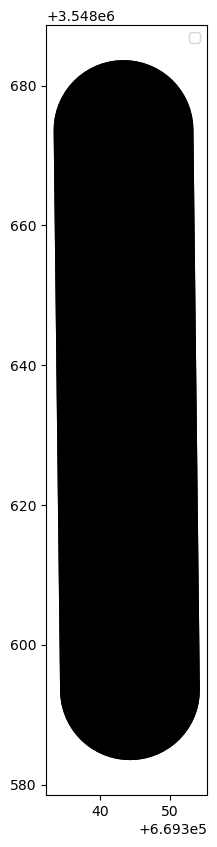

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
accidents_on_street.plot(ax=ax, color='black',linewidth=20)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


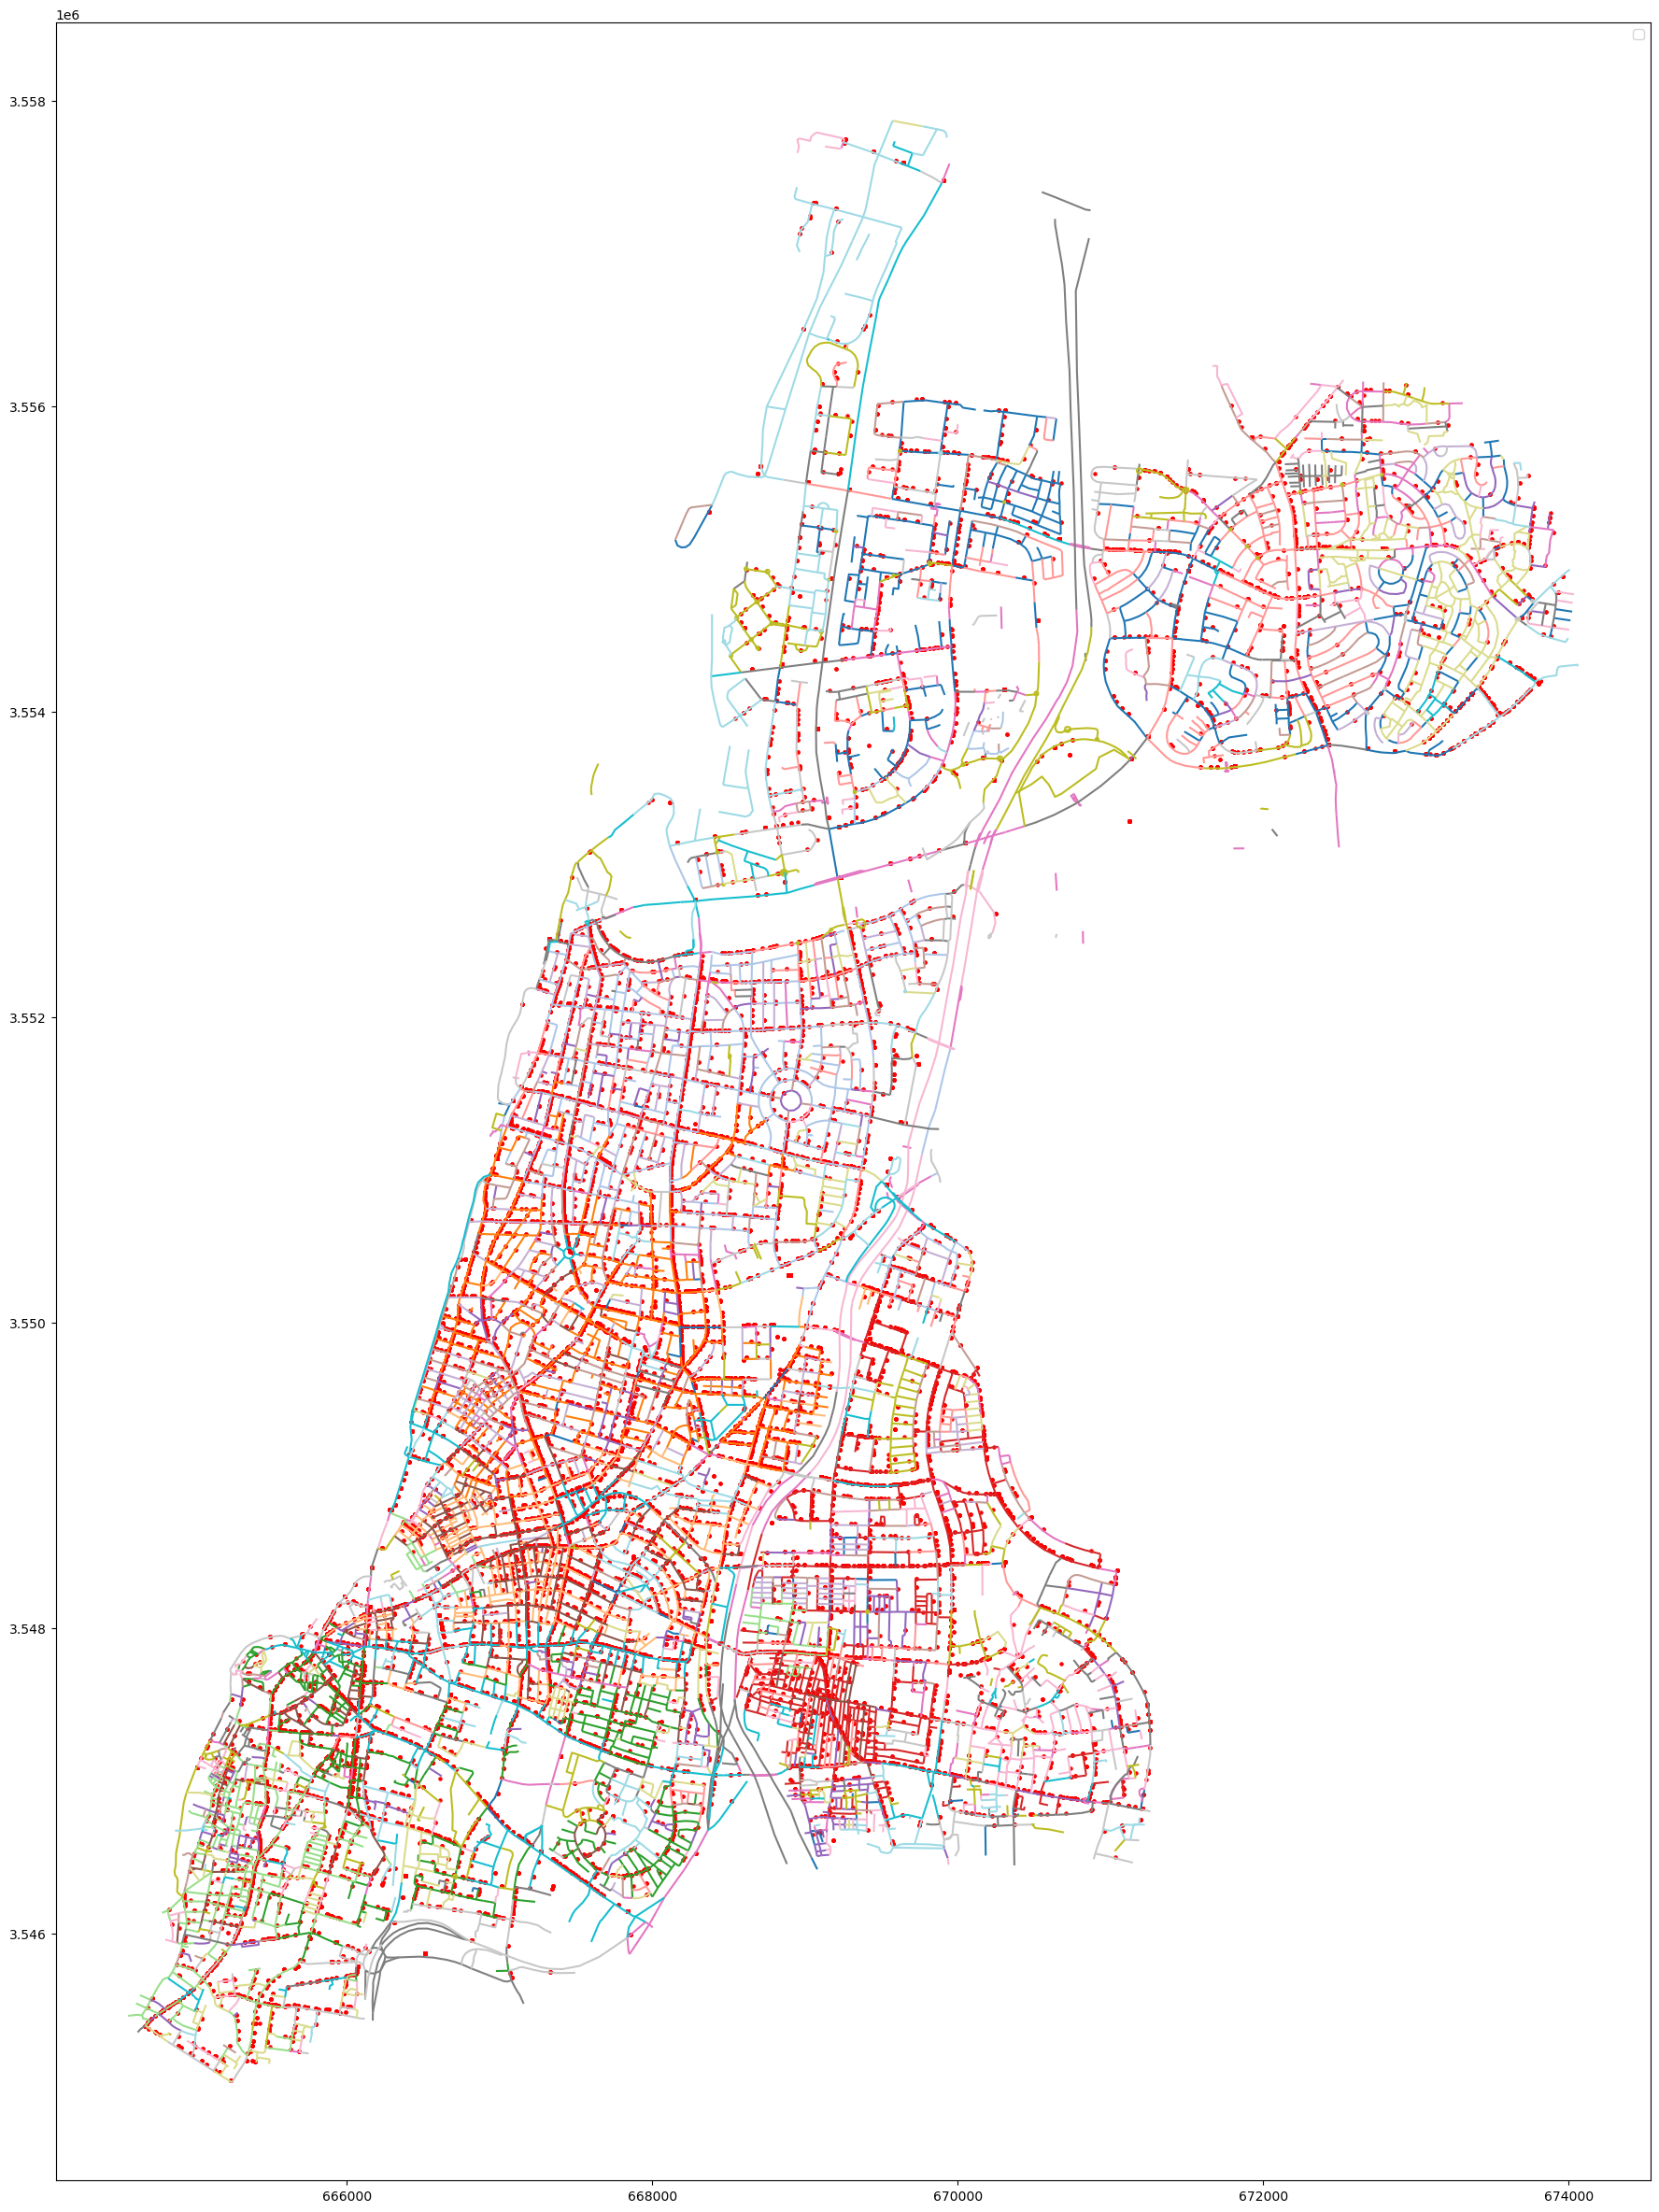

In [22]:

fig, ax = plt.subplots(figsize=(30, 30))
i_m_h_ta_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "רח 1062"].plot(ax=ax, color='black', marker='o', markersize=25, alpha=0.5 )


ta_streets.plot(ax=ax, cmap='tab20')

# accidents_on_street.plot(ax=ax, color='black', label='Specific Bicycle Path', linewidth=5)
# ta_streets[ta_streets.trechov == "מוסנזון בן-ציון דר'"].plot(ax=ax, color='black',linewidth=5)
# ta_streets[ta_streets.trechov == "ח'"].plot(ax=ax, color='black',linewidth=5)
# ta_streets[ta_streets.trechov == "סטימצקי אביגדור"].plot(ax=ax, color='black',linewidth=5)

# ta_q.plot(ax=ax, cmap='tab20', legend=True,)
# bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
# accidents_on_street.plot(ax=ax, color='black', marker='o', markersize=15 )
# i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == "אורי"].plot(ax=ax, color='black', marker='o', markersize=15 )


plt.legend()
plt.show()

In [1]:
# import geopandas as gpd
# from bokeh.io import output_file, show
# from bokeh.models import HoverTool
# from bokeh.plotting import figure
# from bokeh.models import GeoJSONDataSource
# import json

# # Load your data
# # ta_streets = gpd.read_parquet('your_data.parquet')

# # Convert GeoDataFrame to GeoJSON
# geojson_data = json.loads(ta_streets.to_json())

# # Create GeoJSONDataSource
# geo_source = GeoJSONDataSource(geojson=json.dumps(geojson_data))

# # Create a figure
# p = figure(title="Interactive Map with Bokeh", tools="pan,wheel_zoom,reset", active_scroll='wheel_zoom')

# # Add a hover tool
# hover = HoverTool()
# hover.tooltips = [("Street Name", "@trechov")]
# p.add_tools(hover)

# # Add the streets to the map
# p.patches('xs', 'ys', source=geo_source, fill_color='blue', line_color='black', fill_alpha=0.7)

# # Output to an HTML file and show
# output_file("interactive_map.html")
# show(p)


Almost works

---

Trying leafmap

In [24]:
ta_i_m_h_intersect_no_dups[['trechov','street1_hebrew']].head(10)

trechov    street1_hebrew
3   פרנקל ידידיה       נחלת בנימין
7      שאול המלך              None
11       רוטשילד        שד רוטשילד
12         מלצ'ט           שיינקין
13         הכרמל           הכובשים
18   הרברט סמואל  רציף הרברט סמואל
23       לוינסקי        שד הר ציון
30    נמיר מרדכי    דרך נמיר מרדכי
36     רוקח נמיר           שד רוקח
37       וולפסון              הרצל

In [25]:
# pip install leafmap

#### Showing street on map with names

In [26]:
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.str.contains('2291', na=False)][['street1_hebrew','street2_hebrew']]

Empty DataFrame
Columns: [street1_hebrew, street2_hebrew]
Index: []

In [27]:
imh_street_ls = i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.str.contains('2',na=False)]['street1_hebrew'].iloc[10:20].to_list()
imh_street_ls

['רח 2222',
 'רח 4206',
 'רח 3142',
 'רח 3142',
 'רח 3142',
 'רח 428',
 'רח 428',
 'רח 2290',
 'רח 2290',
 'רח 1211']

In [28]:
ta_i_m_h_intersect[ta_i_m_h_intersect.street1_hebrew.isin(imh_street_ls)][['trechov','street1_hebrew']]

trechov street1_hebrew
4923   רצאבי זכריה        רח 4206
7121    יריד המזרח         רח 428
8755    כץ בן-ציון        רח 1211
18337    ארצי יצחק        רח 2222
49215   גלבוע אמיר        רח 2290
95794  רצאבי זכריה        רח 4206

In [29]:
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.str.contains('3',na=False)][['street1_hebrew']].iloc[0:10]

street1_hebrew
4767        רח 3178
4846        רח 3178
5684        רח 3694
5809        רח 3694
5993        רח 3142
5994        רח 3142
5995        רח 3142
6450        רח 3771
6673        רח 3771
8488        רח 3361

In [30]:
ta_streets[ta_streets.trechov.str.contains('10')]

oidrechov  krechov trechov shemangli  mslamas  tsug  kkivun   UniqueId  \
2967     3019.0   1080.0    1080      1080   4036.0  רחוב     3.0  507-13525   
3671     3728.0   1019.0    1019      1019   4031.0  רחוב     0.0  507-14359   
3691     3748.0   1024.0    1024      1024   4032.0  רחוב     0.0  507-14379   
3694     3751.0   1024.0    1024      1024   4032.0  רחוב     0.0  507-14382   
3994     4064.0   1099.0    1099      1099   4039.0  רחוב     3.0  507-14748   
3995     4065.0   1100.0    1100      1100   4040.0  רחוב     3.0  507-14749   
3996     4066.0   1099.0    1099      1099   4039.0  רחוב     3.0  507-14750   
3997     4067.0   1100.0    1100      1100   4040.0  רחוב     3.0  507-14751   
5030     5113.0   1098.0    1098      1098   1566.0  רחוב     2.0  507-15933   
5031     5114.0   1098.0    1098      1098   1566.0  רחוב     2.0  507-15934   
5374     5487.0   9010.0    9010      None      0.0   גשר     0.0  507-16353   
5599     5730.0   1073.0    1073      1073   4035.0  רחוב     0.0  507-16662   
6423     6813.0   1063.0    1063      1063   4034.0  רחוב     0.0  507-18198   
6424     6814.0   1063.0    1063      1063   4034.0  רחוב     3.0  507-18199   
7240     7829.0   2410.0    2410      None   2453.0  רחוב     0.0  507-20502   
7420     8040.0   1310.0    1310      1310   2700.0  רחוב     0.0  507-20705   
7615     8275.0   8101.0    8101      None      0.0  שביל     3.0  507-20905   
7616     8276.0   8101.0    8101      None      0.0  שביל     3.0  507-20907   
7620     8281.0   8105.0    8105      None      0.0  שביל     3.0  507-20913   
7622     8291.0   8104.0    8104      None      0.0  שביל     3.0  507-20919   

     shemarvit  kreka                                           geometry  
2967      1080  100.0  LINESTRING (670223.174 3548944.103, 670315.622...  
3671      1019  100.0  LINESTRING (669519.969 3548208.312, 669519.273...  
3691      1024  100.0  LINESTRING (669321.733 3548008.565, 669361.102...  
3694      1024  100.0  LINESTRING (669361.102 3548008.729, 669408.011...  
3994      1099  100.0  LINESTRING (668455.309 3549581.538, 668455.636...  
3995      1100  100.0  LINESTRING (668520.543 3549577.370, 668522.914...  
3996      1099  100.0  LINESTRING (668453.201 3549529.848, 668455.309...  
3997      1100  100.0  LINESTRING (668519.218 3549525.196, 668520.543...  
5030      1098  100.0  LINESTRING (668383.859 3549583.609, 668378.574...  
5031      1098  100.0  LINESTRING (668383.046 3549632.583, 668383.859...  
5374      9010   50.0  LINESTRING (670381.789 3554118.866, 670396.360...  
5599      1073  100.0  LINESTRING (669703.037 3547584.562, 669776.757...  
6423      1063  100.0  LINESTRING (670538.732 3548134.829, 670518.910...  
6424      1063  100.0  LINESTRING (670600.094 3548346.267, 670641.967...  
7240      2410  100.0  LINESTRING (670660.900 3553979.392, 670661.170...  
7420      1310  100.0  LINESTRING (669032.885 3548701.131, 669033.852...  
7615      8101    0.0  LINESTRING (665192.330 3545209.009, 665273.262...  
7616      8101    0.0  LINESTRING (665273.262 3545157.170, 665303.538...  
7620      8105    0.0  LINESTRING (664949.229 3546923.884, 665032.065...  
7622      8104    0.0  LINESTRING (665678.106 3546359.981, 665700.228...

In [31]:
ta_i_m_h_intersect[ta_i_m_h_intersect.trechov.isin(['גלבוע אמיר'])][['trechov','street1_hebrew']]

trechov street1_hebrew
21896   גלבוע אמיר        רח 2287
49215   גלבוע אמיר        רח 2290
106213  גלבוע אמיר      לוי אשכול

In [32]:
i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.str.contains('1062', na=False)]

Empty GeoDataFrame
Columns: [accident_id, provider_and_id, provider_code, file_type_police, involved_type, involved_type_hebrew, license_acquiring_date, age_group, age_group_hebrew, sex, sex_hebrew, involve_vehicle_type, involve_vehicle_type_hebrew, safety_measures, safety_measures_hebrew, involve_yishuv_symbol, involve_yishuv_name, injury_severity, injury_severity_hebrew, injured_type, injured_type_hebrew, injured_position, injured_position_hebrew, population_type, population_type_hebrew, involve_home_region, involve_home_region_hebrew, involve_home_district, involve_home_district_hebrew, involve_home_natural_area, involve_home_natural_area_hebrew, involve_home_municipal_status, involve_home_municipal_status_hebrew, involve_home_yishuv_shape, involve_home_yishuv_shape_hebrew, hospital_time, hospital_time_hebrew, medical_type, medical_type_hebrew, release_dest, release_dest_hebrew, safety_measures_use, safety_measures_use_hebrew, late_deceased, late_deceased_hebrew, car_id, involve_id, accident_year, accident_month, provider_code_hebrew, accident_timestamp, accident_type, accident_type_hebrew, accident_severity, accident_severity_hebrew, location_accuracy, location_accuracy_hebrew, road_type, road_type_hebrew, road_shape, road_shape_hebrew, day_type, day_type_hebrew, police_unit, police_unit_hebrew, one_lane, one_lane_hebrew, multi_lane, multi_lane_hebrew, speed_limit, speed_limit_hebrew, road_intactness, road_intactness_hebrew, road_width, road_width_hebrew, road_sign, road_sign_hebrew, road_light, road_light_hebrew, road_control, road_control_hebrew, weather, weather_hebrew, road_surface, road_surface_hebrew, road_object, road_object_hebrew, object_distance, object_distance_hebrew, didnt_cross, didnt_cross_hebrew, cross_mode, cross_mode_hebrew, cross_location, cross_location_hebrew, cross_direction, cross_direction_hebrew, road1, road2, km, ...]
Index: []

[0 rows x 162 columns]

In [33]:
ta_streets[ta_streets.trechov.str.contains('מסריק')].trechov.value_counts()

trechov
מסריק    2
Name: count, dtype: int64

In [33]:
import leafmap
import geopandas as gpd

# Load your data
# ta_streets = gpd.read_parquet('your_data.parquet')

# Create a map
m = leafmap.Map(center=(35.0, 35.0), zoom=10)


# Add the GeoDataFrame to the map
# m.add_gdf(accidents_on_street, layer_name="Streets", info_mode='on_hover', hover_style={'fillColor': '#ffaf00', 'color': 'black'})
m.add_gdf(ta_streets[ta_streets.trechov == '3784'], layer_name="Streets", info_mode='on_hover')
# m.add_gdf(i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew.str.contains('3',na=False)].iloc[0:10], layer_name="Streets", info_mode='on_hover', hover_style={'fillColor': '#ffaf00', 'color': 'black'})
# m.add_gdf(i_m_h_ta_gdf[i_m_h_ta_gdf.street1_hebrew == 'אורי'].iloc[0:10], layer_name="Streets", info_mode='on_hover', hover_style={'fillColor': '#ffaf00', 'color': 'black'})

# m.add_gdf(ta_i_m_h_intersect_no_dups, layer_name="Streets", hover_cols=['trechov', 'street1_hebrew'], hover_style={'fillColor': '#ffaf00', 'color': 'black'})


# m.add_gdf(ta_i_m_h_intersect[ta_i_m_h_intersect.trechov.isin(['0'])]
# , layer_name="Streets", info_mode='on_hover', 
#           hover_style={'fillColor': '#ffaf00', 'color': 'black'}, 
#           fields=['trechov', 'street1_hebrew'])
m.add_gdf(ta_crossroads_, layer_name="Crossroads", info_mode='on_hover')


# Display the map
m


ValueError: Can't clean for JSON: <POLYGON ((6.7e+05 3.56e+06, 6.7e+05 3.56e+06, 6.7e+05 3.56e+06, 6.7e+05 3.5...>

### Found out that איילון is not in i_m_h_ta_gdf

So I will use the method of intersection to correct street names.

Conclusion:

There are no accidents on AYALON!

In [75]:
ta_streets_buffered = ta_streets.copy()
ta_streets_buffered.geometry = ta_streets_buffered.geometry.buffer(10)
# ta_streets_fix_with_intersection.geometry = ta_streets_fix_with_intersection.geometry.buffer(10)
ta_i_m_h_intersection = gpd.sjoin(i_m_h_ta_gdf, ta_streets_buffered, how='inner', predicate='intersects')

# ta_i_m_h_intersection = gpd.sjoin(ta_streets_fix_with_intersection, i_m_h_ta_gdf_fix_with_intersection , how='inner', predicate='intersects')


ta_i_m_h_intersection

accident_id  provider_and_id  provider_code  file_type_police  \
0        2013000873      12013000873              1                 1   
0        2013000873      12013000873              1                 1   
0        2013000873      12013000873              1                 1   
0        2013000873      12013000873              1                 1   
1        2013002190      12013002190              1                 1   
...             ...              ...            ...               ...   
111405   2024097713      12024097713              1                 1   
111406   2024099291      32024099291              3                 3   
111407   2024096597      32024096597              3                 3   
111407   2024096597      32024096597              3                 3   
111407   2024096597      32024096597              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
0                   2             נהג נפגע                    1980         11   
0                   2             נהג נפגע                    1980         11   
0                   2             נהג נפגע                    1980         11   
0                   2             נהג נפגע                    1980         11   
1                   1                  נהג                       0         99   
...               ...                  ...                     ...        ...   
111405              1                  נהג                    1998         13   
111406              1                  נהג                       0         99   
111407              2             נהג נפגע                    1993         11   
111407              2             נהג נפגע                    1993         11   
111407              2             נהג נפגע                    1993         11   

       age_group_hebrew  sex  ... oidrechov  krechov               trechov  \
0                 50-54    1  ...    9004.0   3311.0           קבוץ גלויות   
0                 50-54    1  ...    9000.0   3585.0            חיל השריון   
0                 50-54    1  ...    9003.0   3585.0            חיל השריון   
0                 50-54    1  ...    6786.0   6200.0  כ.מוולפסון לצפון6200   
1               לא ידוע    0  ...     737.0    496.0            אבן גבירול   
...                 ...  ...  ...       ...      ...                   ...   
111405            60-64    1  ...    3070.0   1064.0               בת ציון   
111406          לא ידוע    0  ...    7444.0   2106.0             אשכול לוי   
111407            50-54    2  ...    8179.0   3000.0                בן צבי   
111407            50-54    2  ...    8062.0   3000.0                בן צבי   
111407            50-54    2  ...    2170.0   3838.0                  3838   

              shemangli mslamas  tsug kkivun   UniqueId  \
0       Kibbuts Galuiot  2309.0   דרך    0.0  507-17620   
0         HEIL HASIRYON  2465.0   דרך    0.0  507-12118   
0         HEIL HASIRYON  2465.0   דרך    0.0  507-18111   
0                  None     0.0   גשר    0.0  507-18161   
1            IBN GVIROL  1040.0  רחוב    0.0  507-10863   
...                 ...     ...   ...    ...        ...   
111405       BAT TSIYON  2645.0  רחוב    0.0  507-13591   
111406      LEVI ESHKOL   197.0  רחוב    0.0  507-10270   
111407          BEN ZVI  2412.0   דרך    0.0  507-12546   
111407          BEN ZVI  2412.0   דרך    0.0  507-20736   
111407             3838  4713.0  רחוב    0.0  507-12548   

                               shemarvit  kreka  
0                 بطاقات بريدية Kabbalah  200.0  
0                              فيلق مدرع  200.0  
0                              فيلق مدرع  200.0  
0       بصفته وولفسون إلى الشمال من 6200   50.0  
1                             حجر غفيرول  200.0  
...                                  ...    ...  
111405                    الخفافيش صهيون  100.0  
111406                     ضريبة الموضوع  200.0  
111407                            بن زفي  200.0  
111407      

Difference between 'trechov','street1_hebrew'

In [81]:
ta_i_m_h_intersection[ta_i_m_h_intersection.street1_hebrew != ta_i_m_h_intersection.trechov][['trechov','street1_hebrew']].drop_duplicates()

trechov street1_hebrew
0                 חיל השריון    קבוץ גלויות
0       כ.מוולפסון לצפון6200    קבוץ גלויות
3               פרנקל ידידיה    נחלת בנימין
7                  שאול המלך           None
10                   סוקולוב            בזל
...                      ...            ...
110712            כנפי נשרים          דניאל
110765                 הרנ"ה           בושם
111240                  השוק        וולפסון
111250          פנקס דוד צבי     עקיבא אריה
111355           ברקאי שמואל          הנוטר

[3553 rows x 2 columns]

In [84]:
ta_i_m_h_intersection[ta_i_m_h_intersection.trechov.str.contains('אילון')][['trechov','street1_hebrew']]

Empty DataFrame
Columns: [trechov, street1_hebrew]
Index: []

### Checking crossroads that have taken unrelated roads

In [ ]:
# First check crossroads with the most streets.
crossroads_buff.num_trechov.sort_values().tail(50)

2212     5
1027     5
1836     5
902      5
2497     5
3203     5
3057     5
5540     5
2830     5
1717     5
2956     5
4825     5
600      5
966      5
1899     5
1003     5
2081     5
3088     5
4838     5
5410     5
1379     5
660      5
4246     5
2473     5
592      5
3629     5
797      5
1896     5
1951     5
1799     5
1655     6
2073     6
1849     6
1677     6
2644     6
1369     6
1113     6
1632     6
881      6
1619     6
394      6
1470     7
1698     7
1107     7
733      7
1121     7
1436     8
978      8
2466     9
2508    10
Name: num_trechov, dtype: int64

In [ ]:
ta_crossroads_from_streets

oidrechov  krechov      trechov        shemangli  mslamas  tsug  \
0            1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב   
1            1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב   
2            2.0      0.0            0           UKNOWN      0.0  רחוב   
3            2.0      0.0            0           UKNOWN      0.0  רחוב   
4            3.0    265.0      אמסטרדם        AMSTERDAM    516.0  רחוב   
...          ...      ...          ...              ...      ...   ...   
16955     9853.0   3058.0  אבינרי יצחק          AVINERY   2027.0  רחוב   
16956     9855.0   3907.0         3907             None   1703.0  רחוב   
16957     9855.0   3907.0         3907             None   1703.0  רחוב   
16958     9857.0     34.0        מטלון          MATALON   2327.0  רחוב   
16959     9857.0     34.0        מטלון          MATALON   2327.0  רחוב   

       kkivun   UniqueId       shemarvit  kreka  \
0         0.0  507-10001       قتل مملكة  100.0   
1         0.0  507-10001       قتل مملكة  100.0   
2         3.0  507-10002            None  100.0   
3         3.0  507-10002            None  100.0   
4         1.0  507-10003        أمستردام  100.0   
...       ...        ...             ...    ...   
16955     0.0  507-20563  Avinri Yitzhak  100.0   
16956     0.0  507-21960            3907  100.0   
16957     0.0  507-21960            3907  100.0   
16958     0.0  507-21966         ميتالون  100.0   
16959     0.0  507-21966         ميتالون  100.0   

                                                geometry  
0      POLYGON ((672877.060 3554095.248, 672877.488 3...  
1      POLYGON ((672897.454 3554085.041, 672897.881 3...  
2      POLYGON ((667001.092 3551440.515, 667001.574 3...  
3      POLYGON ((667066.026 3551431.484, 667066.508 3...  
4      POLYGON ((667890.678 3551426.339, 667891.144 3...  
...                                                  ...  
16955  POLYGON ((665773.879 3547027.713, 665774.316 3...  
16956  POLYGON ((665076.333 3546673.937, 665075.855 3...  
16957  POLYGON ((665055.581 3546679.613, 665055.117 3...  
16958  POLYGON ((666926.401 3548298.299, 666926.887 3...  
16959  POLYGON ((666959.723 3548304.236, 666960.210 3...  

[16960 rows x 11 columns]

In [ ]:
orig_cross_with_created_cross = gpd.sjoin(ta_crossroads_from_streets, crossroads_buff[['combined_trechov','geometry','num_trechov']])

orig_idx_to_check = orig_cross_with_created_cross[orig_cross_with_created_cross.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')].index
orig_idx_to_check

Index([], dtype='int64')

In [ ]:
import leafmap
m = leafmap.Map(center=(32.047, 34.785), zoom=11)
# m.add_gdf(crossroads_buff[crossroads_buff.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')], layer_name="Streets", fill_colors='black', zoom_to_layer=True)
# m.add_gdf(orig_cross_with_created_cross[orig_cross_with_created_cross.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')], layer_name="Streets", fill_colors='black', zoom_to_layer=True)
m.add_gdf(ta_crossroads_from_streets.loc[orig_idx_to_check], layer_name="crossroad_to_check", fill_colors='black', zoom_to_layer=True)
m.add_gdf(ta_streets, layer_name="Streets", fill_colors='black',)
m.add_gdf(ta_crossroads, layer_name="Streets", fill_colors='black',)

m

The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.


Map(center=[32.047, 34.785], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

We see issues with our map, "קיבוץ גלויות" is a two way street but only one line string, when connecting to other streets it creates a connection that is missing the real street connections.

Hence the crossroads are misaligned. 

---

Trying Open Street Map

In [ ]:
import networkx as nx
import osmnx as ox

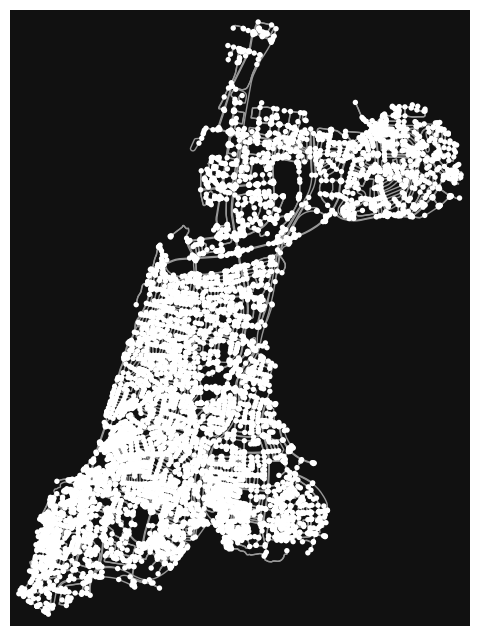

In [ ]:
G = ox.graph_from_place("Tel Aviv, Israel", network_type="drive")
fig, ax = ox.plot_graph(G)

In [ ]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

y          x          highway  street_count  ref  \
osmid                                                              
139693  32.093840  34.790572  traffic_signals             4  NaN   
139698  32.093869  34.791231              NaN             3  NaN   
139707  32.095354  34.778500              NaN             3  NaN   
139708  32.095052  34.778329              NaN             3  NaN   
139709  32.094527  34.778842              NaN             4  NaN   

                         geometry  
osmid                              
139693  POINT (34.79057 32.09384)  
139698  POINT (34.79123 32.09387)  
139707  POINT (34.77850 32.09535)  
139708  POINT (34.77833 32.09505)  
139709  POINT (34.77884 32.09453)

<Axes: >

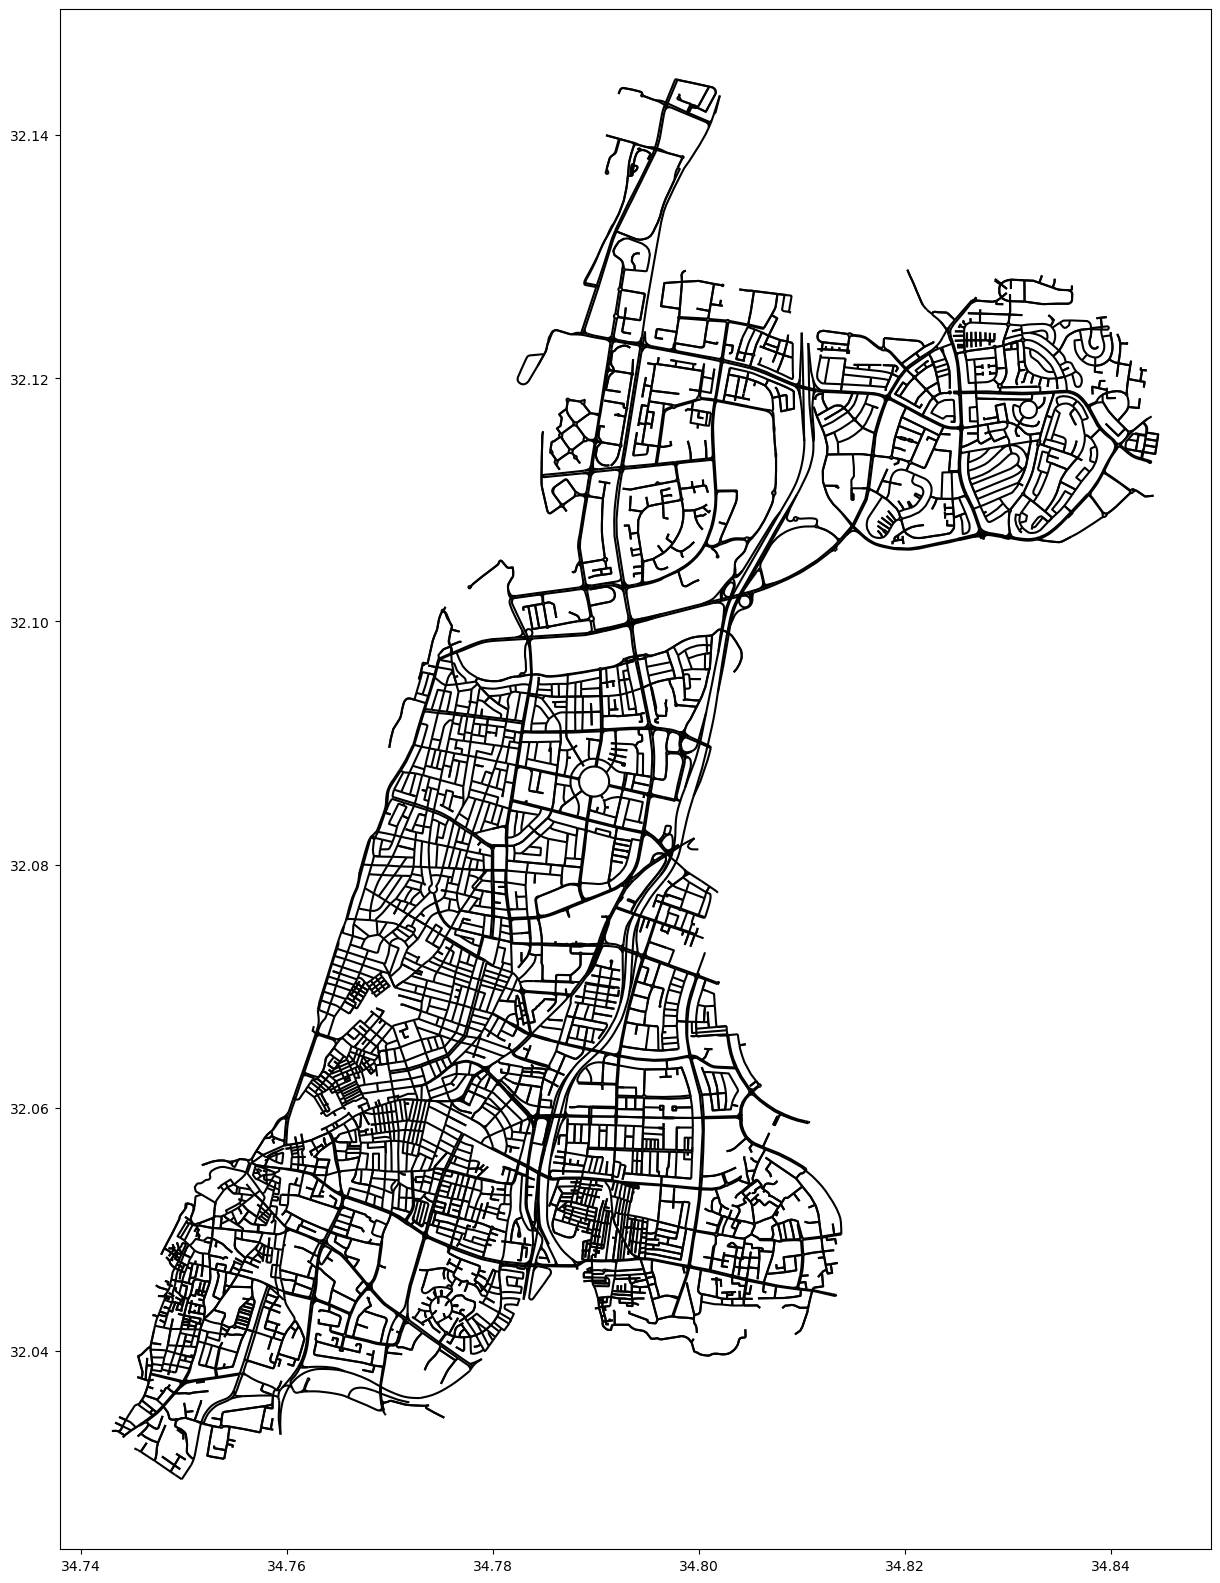

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

gdf_edges.plot(ax=ax, color='black')

In [ ]:
ta_crossroads_from_streets.loc[orig_idx_to_check]

Empty GeoDataFrame
Columns: [oidrechov, krechov, trechov, shemangli, mslamas, tsug, kkivun, UniqueId, shemarvit, kreka, geometry]
Index: []

In [ ]:
import leafmap
m = leafmap.Map(center=(32.047, 34.785), zoom=11)
# m.add_gdf(crossroads_buff[crossroads_buff.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')], layer_name="Streets", fill_colors='black', zoom_to_layer=True)
# m.add_gdf(orig_cross_with_created_cross[orig_cross_with_created_cross.combined_trechov.str.contains('קבוץ גלויות,איילון לכוון וולפסון')], layer_name="Streets", fill_colors='black', zoom_to_layer=True)
m.add_gdf(ta_crossroads_from_streets.loc[orig_idx_to_check], layer_name="crossroad_to_check", fill_colors='black', zoom_to_layer=True)
# m.add_gdf(ta_streets, layer_name="Streets", fill_colors='red',)
m.add_gdf(gdf_edges, layer_name="open_streets_map_edges", fill_colors='black',)
# m.add_gdf(gdf_nodes[gdf_nodes.street_count > 1] , layer_name="open_streets_map_nodes", fill_colors='black',)


m

The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.


Map(center=[32.047, 34.785], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [ ]:
gdf_nodes[gdf_nodes.street_count > 1].crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich